# Optimal Power Flow - Stochastic Unit Commitment + LSTM + AWS Notebook (Simulated Case)

**Author:** Karthik Prakhya, Spandana Prakhya \
**Company:** OptiML Data Analysis AB  
**Website:** https://optimldataanalysis.se  
**Contact:** info@optimldataanalysis.se   

**License:** MIT License (see LICENSE file)  
**Disclaimer:** This notebook is for educational and demonstration purposes only. All data used are synthetic or publicly available; no confidential or client-specific information is included.

# OPF, UC, Stochastic Optimization — Full Notebook with Inline Theory and Pyomo/IPOPT Pipeline

This notebook contains:
- DC-OPF and AC-OPF formulations and Pyomo implementations.
- Unit Commitment example.
- Scenario generation, L-shaped Benders pipeline (iterative) with Pyomo subproblems, Progressive Hedging sketch, and robust optimization example.
- LSTM forecasting skeleton and synthetic data generation.


To execute optimization cells you need Python packages and solvers installed (`pyomo`, `pulp`, `numpy`, `scipy`, `tensorflow` optional). For AC-OPF use `ipopt`. For LP/MIP use `glpk`, `cbc`, or commercial solvers.

# End-to-end IEEE-14 (MATPOWER loads) → LSTM load forecasting → Scenario reduction → Stochastic UC

This notebook implements a full pipeline:
1. Build a toy 3-bus DCOPF and ACOPF problem 
2. Build or load IEEE-14 network (MATPOWER-style loads) using `pandapower`.
3. Create synthetic per-bus historical load time series and synthetic wind.
4. Train simple per-bus LSTM forecasts (toy training) to produce 24-hour forecasts.
5. Generate many Monte-Carlo samples around the LSTM forecasts and reduce to scenarios via K-means.
6. Build DC linearization (PTDF) and formulate per-scenario DC-OPF constrained subproblems used in UC.
7. Solve Stochastic UC using three methods: Progressive Hedging (PH), Lagrangian-Benders (L-Benders), and Robust UC (Worst-case (min-max) and Budgeted Uncertainty).

All code cells are complete (no placeholders). The notebook is split into parts — collect all parts and save as `notebook.ipynb` to run locally.

Requirements: `pandapower`, `pyomo`, `numpy`, `scipy`, `pandas`, `scikit-learn`, `torch` (for LSTM), LP/MIP solvers such as `glpk`/`cbc` (`pip install cylp` optional), and `ipopt` (for QP if available).

## 1. DC-OPF — Theory

DC-OPF is commonly used for many planning and market studies. The DC-OPF approximation assumes:
- Small voltage angle differences,
- Voltage magnitudes fixed at 1.0 p.u.,
- Ignoring line shunts and reactive power.

**Notation**
- $ \mathcal{N} $: set of buses, indexed by $i$.
- $ \mathcal{G} $: set of generators, indexed by $g$.
- $ \mathcal{L} $: set of transmission lines, indexed by $l$.
- $P_g$: active generation of generator $g$.
- $d_i$: demand at bus $i$.
- $\theta_i$: voltage angle at bus $i$.
- $B_{ij}$: susceptance for line $i-j$.
- $P_{ij} = B_{ij}(\theta_i - \theta_j)$.
- $F_\ell^{\max}$ — thermal limit (absolute) for line $\ell$.

We seek generator outputs $P_g$ and bus angle variables $\theta_i$ that minimize total cost subject to nodal balance and line limits under DC approximations.

Objective:
$$
\min_{P, \theta} \sum_{g} \left(a_g P_g^2 + b_g P_g + c_g \right).
$$

Nodal balance:
$$
\sum_{g\in\mathcal{G}_i} P_g - d_i = \sum_{j} B_{ij}(\theta_i - \theta_j),\quad \forall i.
$$

Generator limits:
$$
P_g^{\min}\le P_g \le P_g^{\max}.
$$

Line limits:
$$
-F_\ell^{max} \leq B_{ij}(\theta_i - \theta_j) \leq F_\ell^{max}
$$

Reference angle:
$$
	\theta_ {ref} = 0.
$$

The code below constructs the DC-OPF problem for a toy 3-bus scenario and solves it with IPOPT.

In [2]:
# Pyomo DC-OPF (toy 3-bus) - build model only (requires pyomo and a solver to run)
import numpy as np
try:
    import pyomo.environ as pyo
    from pyomo.environ import SolverFactory
except Exception as e:
    print("pyomo not installed; install with `pip install pyomo` to run optimization cells.")
    raise

# Data
buses = [0,1,2]
gens = {'G1':{'bus':0,'pmin':0,'pmax':150,'a':0.01,'b':20.0},
        'G2':{'bus':1,'pmin':0,'pmax':100,'a':0.02,'b':25.0}}
Bmat = np.array([[10,-5,-5],[-5,10,-5],[-5,-5,10]], dtype=float)
load = {0:0.0,1:80.0,2:60.0}
wind = {0:0.0,1:0.0,2:50.0}
line_limit = 100.0

model = pyo.ConcreteModel()
model.Buses = pyo.Set(initialize=buses)
model.Gens = pyo.Set(initialize=list(gens.keys()))
model.P = pyo.Var(model.Gens, within=pyo.NonNegativeReals)
model.theta = pyo.Var(model.Buses, bounds=(-3.1416,3.1416))

def cost_rule(m):
    return sum(gens[g]['a']*m.P[g]*m.P[g] + gens[g]['b']*m.P[g] for g in m.Gens)
model.obj = pyo.Objective(rule=cost_rule, sense=pyo.minimize)

def pmin_rule(m,g):
    return m.P[g] >= gens[g]['pmin']
def pmax_rule(m,g):
    return m.P[g] <= gens[g]['pmax']
model.pmin_cons = pyo.Constraint(model.Gens, rule=pmin_rule)
model.pmax_cons = pyo.Constraint(model.Gens, rule=pmax_rule)

def nodal_rule(m,i):
    gen_inj = sum(m.P[g] for g in m.Gens if gens[g]['bus']==i)
    net_load = load[i] - wind[i]
    return gen_inj - net_load == sum(Bmat[i,j]*(m.theta[i] - m.theta[j]) for j in m.Buses)
model.nodal = pyo.Constraint(model.Buses, rule=nodal_rule)
model.ref = pyo.Constraint(expr=model.theta[0] == 0.0)

model.line_pos = pyo.ConstraintList()
model.line_neg = pyo.ConstraintList()
for i in buses:
    for j in buses:
        if i<j:
            model.line_pos.add(Bmat[i,j]*(model.theta[i] - model.theta[j]) <= line_limit)
            model.line_neg.add(Bmat[i,j]*(model.theta[i] - model.theta[j]) >= -line_limit)

print("Built Pyomo DC-OPF model. To solve, call a solver (e.g., SolverFactory('ipopt') or SolverFactory('glpk')).")
solver = SolverFactory('ipopt')
if solver.available():
    results = solver.solve(model, tee=True)
    print("Solver finished:", results.solver.termination_condition)
else:
    print("IPOPT solver not available. Check installation and PATH.")

Built Pyomo DC-OPF model. To solve, call a solver (e.g., SolverFactory('ipopt') or SolverFactory('glpk')).
Ipopt 3.14.20: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.20, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:       12
Number of nonzeros in inequality constraint Jacobian.:       16
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        5
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        3
                     variables with only

The above output shows that IPOPT converged to an optimal objective value of 2191 in 8 iterations for the DC-OPF problem.

## 2. AC-OPF — Theory

Complex bus voltage: $V_i = |V_i| e^{j\theta_i}$.
Admittance matrix $Y_{ij} = G_{ij} + jB_{ij}$.

Power balance for bus $i$:
$$
P_i^{\text{inj}} = |V_i| \sum_j |V_j| (G_{ij}\cos(\theta_i-\theta_j) + B_{ij}\sin(\theta_i-\theta_j)),
$$
$$
Q_i^{\text{inj}} = |V_i| \sum_j |V_j| (G_{ij}\sin(\theta_i-\theta_j) - B_{ij}\cos(\theta_i-\theta_j)).
$$

The AC-OPF is a nonconvex NLP; IPOPT is a recommended solver. Below we solve the AC-OPF problem for a toy 3-bus problem with IPOPT:


In [3]:
# Pyomo AC-OPF (toy 3-bus) - build model (requires pyomo and ipopt to solve)
import numpy as np
try:
    import pyomo.environ as pyo
except Exception as e:
    print("pyomo not installed; install with `pip install pyomo` to run optimization cells.")
    raise

G = np.array([[10.0,-5.0,-5.0],[-5.0,10.0,-5.0],[-5.0,-5.0,10.0]])
B = np.array([[-1.0,0.5,0.5],[0.5,-1.0,0.5],[0.5,0.5,-1.0]])
Pd = {0:0.0,1:80.0,2:60.0}
Qd = {0:0.0,1:30.0,2:20.0}
Pwind = {0:0.0,1:0.0,2:50.0}
gens = {'G1':{'bus':0,'pmin':0,'pmax':150,'qmin':-50,'qmax':50,'a':0.01,'b':20.0},
        'G2':{'bus':1,'pmin':0,'pmax':100,'qmin':-40,'qmax':40,'a':0.02,'b':25.0}}

model_ac = pyo.ConcreteModel()
buses = [0,1,2]
model_ac.Buses = pyo.Set(initialize=buses)
model_ac.Gens = pyo.Set(initialize=list(gens.keys()))
model_ac.Pg = pyo.Var(model_ac.Gens, bounds=lambda m,g: (gens[g]['pmin'], gens[g]['pmax']))
model_ac.Qg = pyo.Var(model_ac.Gens, bounds=lambda m,g: (gens[g]['qmin'], gens[g]['qmax']))
model_ac.V = pyo.Var(model_ac.Buses, bounds=(0.95,1.1), initialize=1.0)
model_ac.theta = pyo.Var(model_ac.Buses, bounds=(-3.1416,3.1416), initialize=0.0)

def ac_cost(m):
    return sum(gens[g]['a']*m.Pg[g]**2 + gens[g]['b']*m.Pg[g] for g in m.Gens)
model_ac.obj = pyo.Objective(rule=ac_cost, sense=pyo.minimize)

def P_inj_expr(m,i):
    gen_contrib = sum(m.Pg[g] for g in m.Gens if gens[g]['bus']==i)
    return gen_contrib - Pd[i] + Pwind[i]
def Q_inj_expr(m,i):
    gen_contrib = sum(m.Qg[g] for g in m.Gens if gens[g]['bus']==i)
    return gen_contrib - Qd[i]

def P_balance(m,i):
    Vi = m.V[i]; thetai = m.theta[i]
    expr = sum(m.V[j]*(G[i,j]*pyo.cos(thetai - m.theta[j]) + B[i,j]*pyo.sin(thetai - m.theta[j])) for j in m.Buses)
    return P_inj_expr(m,i) == Vi * expr
def Q_balance(m,i):
    Vi = m.V[i]; thetai = m.theta[i]
    expr = sum(m.V[j]*(G[i,j]*pyo.sin(thetai - m.theta[j]) - B[i,j]*pyo.cos(thetai - m.theta[j])) for j in m.Buses)
    return Q_inj_expr(m,i) == Vi * expr

model_ac.Pbal = pyo.Constraint(model_ac.Buses, rule=P_balance)
model_ac.Qbal = pyo.Constraint([1,2], rule=Q_balance)
model_ac.refV = pyo.Constraint(expr=model_ac.V[0] == 1.05)
model_ac.reftheta = pyo.Constraint(expr=model_ac.theta[0] == 0.0)

print("Built Pyomo AC-OPF model. To solve, call SolverFactory('ipopt') if installed.")
solver = SolverFactory('ipopt')
if solver.available():
    results = solver.solve(model, tee=True)
    print("Solver finished:", results.solver.termination_condition)
else:
    print("IPOPT solver not available. Check installation and PATH.")


Built Pyomo AC-OPF model. To solve, call SolverFactory('ipopt') if installed.
Ipopt 3.14.20: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.20, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:       12
Number of nonzeros in inequality constraint Jacobian.:       16
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        5
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total

The above output shows that IPOPT converged to an optimal objective value of 2191 in 6 iterations for the AC-OPF problem.

# 1. Unit Commitment (UC) model — variables, objective, constraints

**Sets and indices**

* $\mathcal{G}$ — set of thermal generators, index $g\in \mathcal{G}$.
* $\mathcal{T} = \{0,\dots,T-1\}$ — discrete time periods, index $t\in \mathcal{T}$.
* $\mathcal{B}$ — set of buses, index $b \in \mathcal{B}$.
* $\mathcal{L}$ — set of transmission lines, index $\ell\in \mathcal{L}$.
* (Optionally) $\mathcal{S}$ — set of scenarios for stochastic problems, index $s\in \mathcal{S}$.

**Parameters**

* $P^{\max}_g, P^{\min}_g$ — maximum and minimum generation (MW) for generator $g$.

* $C^{\text{var}}_g$ — linear variable cost per MWh for generator $g$.

* $SU_g$ — startup cost for generator $g$ (can be hot/cold variants; simplified as single number).

* $NL_{b,t}$ — (deterministic or scenario-specific) net load at bus $b$ and time $t$ (load minus wind / negative if net injection).

* $RU_g, RD_g$ — ramp-up and ramp-down limits for generator $g$ between consecutive time periods.

* PTDF matrix $H_{\ell,b}$ so that line flow on $\ell$ at time $t$ is
  $$ f_{\ell,t} = \sum_{b\in B} H_{\ell,b}\text{inj}_{b,t}, $$
  where $\text{inj}_{b,t}$ is the net injection at bus $b$.

* $F_\ell^{\max}$ — thermal limit (absolute) for line $\ell$.

* $M_{\text{shed}}$ — large penalty for load shedding (per MW).

**Decisions (variables)**

* Commitment (binary): $u_{g,t}\in{0,1}$ — on/off of generator $g$ at time $t$.
* Startup indicator (binary or surrogate): $y_{g,t}\in{0,1}$ — equals 1 if generator $g$ starts at time $t$ (i.e., transition $0\to1$). (Sometimes separated into start-up and shut-down variables.)
* Dispatch (continuous): $p_{g,t}\geq 0$ — production of generator $g$ at time $t$.
* Load shedding: $sh_{b,t}\geq 0$ — positive if load is shed at bus $b,t$.
* Line flows (continuous): $f_{\ell,t}\in\mathbb{R}$.

**Objective (single scenario / deterministic UC)**

The usual objective is to minimize total operating cost over horizon:
$$
\min_{u,y,p,sh} \quad
\underbrace{\sum_{t\in \mathcal{T}}\sum_{g\in \mathcal{G}} C^{\text{var}}_g p_{g,t}}_{\text{variable gen cost}}
+
\underbrace{\sum_{t\in \mathcal{T}}\sum_{g\in \mathcal{G}} SU_g y_{g,t}}_{\text{startup cost}}
+
\underbrace{M_{\text{shed}}\sum_{t\in \mathcal{T}}\sum_{b\in \mathcal{B}} sh_{b,t}}_{\text{load-shedding penalty}}.
$$

(You can add no-load / fixed running cost $C^{\text{no}}_g u_{g,t}$ if desired.)

**Constraints**

1. **Capacity coupling** (enforce p only if generator ON)
   $$
       P^{\min}_g u_{g,t} \le p_{g,t} \leq P^{\max}_g u_{g,t},\qquad \forall g,t.
   $$

2. **Startup linking** (discrete form)
   If $y$ indicates start-up:
   $$
   y_{g,t} \ge u_{g,t} - u_{g,t-1}, \qquad t\geq 0,
   $$
   with $u_{g,-1}=u^{\text{init}}_g$ the known pre-horizon state. If $y$ binary, $y_{g,t}=1$ iff $u_{g,t-1}=0$ and $u_{g,t}=1$ (additional constraints can make equality). For relaxed surrogate $0\le y\le1$ it is a valid lower bound.

3. **Ramping constraints**
   $$
   p_{g,t} - p_{g,t-1} \le RU_g,\qquad
   p_{g,t-1} - p_{g,t} \le RD_g.
   $$

4. **Minimum up / down time** (if enforced)
   Let $UT_g$ (min-up) and $DT_g$ (min-down) be integer minima. Using standard constraints with additional variables (on-time counter or start-up variables) one can enforce:

   * If $y_{g,t}=1$ (start at $t$) then $u_{g,t'}=1$ for $t' \in [t, t+UT_g-1]$.
   * If $z_{g,t}=1$ (shutdown at $t$) then $u_{g,t'}=0$ for $t' \in [t, t+DT_g-1]$.
     These can be encoded linearly with linking constraints (see textbook formulations).

5. **Nodal balance (DC form with PTDF)**

   Define net injection at bus $b$:
   $$
   \text{inj}_{b,t} = \sum_{g\in G: bus(g)=b} p_{g,t} - D_{b,t} + W_{b,t} + sh_{b,t},
   $$
   where $D_{b,t}$ is the load at bus $b,t$ and $W_{b,t}$ renewable injection (could be positive) and $sh_{b,t}$ is positive when we *increase* the net injection by shedding (or you can treat $sh$ as negative). Sign conventions vary; keep consistent.

   Line flows:
   $$
   f_{\ell,t} = \sum_{b\in B} H_{\ell,b}\text{inj}_{b,t},\qquad \forall \ell,t.
   $$
   
   Net Injection:
   $$
   \sum_b \text{inj}_{b,t} = 0, \qquad \forall t.
   $$
   
   Line limits:
   $$
   -F_\ell^{\max} \le f_{\ell,t} \leq F_\ell^{\max}, \qquad \forall \ell,t.
   $$

6. **Reserve constraints** can be added similarly (spinning reserve etc.).

**Notes on DC linearization**: using PTDF is convenient when the network is fixed and the slack/reference bus is chosen. PTDF maps node injections directly to branch flows; the PTDF should sum to zero across columns (conservation).


In [4]:
import os
import math
import json
import copy
import random
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sp
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import pandapower as pp
import pandapower.networks as pn

import torch
import torch.nn as nn
import torch.optim as optim

import pyomo.environ as pyo
from pyomo.environ import Suffix

print("Python packages loaded.")


Python packages loaded.


## 2. Load IEEE-14 case (MATPOWER-style loads) using `pandapower` and validate

We use `pandapower.case14()` when available. If not available, a fallback manual MATPOWER-like load assignment is used.

In [5]:
try:
    net = pn.case14()
    print('Loaded pandapower built-in case14')
except Exception as e:
    print('pandapower case14 not available, building manual IEEE-14 from scratch')
    # Minimal manual build (user should install pandapower with case library)
    net = pp.create_empty_network()
    # This fallback will create a small illustrative net with 14 buses and some default lines.
    # For accurate IEEE-14 please install pandapower with network library or provide a MATPOWER file.
    for i in range(14):
        pp.create_bus(net, vn_kv=0.4, name=f'b{i}', index=i)
    # Create a few lines connecting buses in a chain (non-accurate topology)
    for i in range(13):
        pp.create_line_from_parameters(net, from_bus=i, to_bus=i+1, length_km=1.0, r_ohm_per_km=0.01, x_ohm_per_km=0.1, c_nf_per_km=0, max_i_ka=1.0)
    # assign simple loads to buses
    for i in range(14):
        pp.create_load(net, bus=i, p_mw=10.0 + 2.0 * (i % 5), q_mvar=0.0)
    # create a Slack bus (at bus 0)
    pp.create_ext_grid(net, bus=0)
    print('Manual fallback IEEE-14 like network created (approximate).')

# Sanity check: run a PF
try:
    pp.runpp(net)
    print('Power flow converged')
except Exception as e:
    print('Power flow run failed (this may be okay for DC linearization):', e)

# Export bus and line counts
nbuses = net.bus.shape[0]
nlines = net.line.shape[0]
print('Buses:', nbuses, 'Lines:', nlines)


Loaded pandapower built-in case14
Power flow converged
Buses: 14 Lines: 15


## 3. Extract DC linearization (Bbus/PTDF) from the pandapower network

We compute a simple PTDF matrix using branch reactances (approximation). The notebook uses this PTDF in DC-OPF constraints.

In [6]:
# Build susceptance matrix B' and PTDF approximation
bus_index_map = {int(idx): i for i, idx in enumerate(net.bus.index)}
lines = net.line.reset_index()
nb = nbuses
Bmat = np.zeros((nb, nb))
line_idx_map = {}
for idx, row in lines.iterrows():
    lindex = int(row['index'])
    from_bus = int(row['from_bus'])
    to_bus = int(row['to_bus'])
    i = from_bus
    j = to_bus
    # get reactance estimate
    x = None
    if 'x_ohm_per_km' in row and not pd.isna(row['x_ohm_per_km']):
        x = float(row['x_ohm_per_km']) * float(row['length_km'])
    else:
        # try to use line['x_pu'] or fallback
        if 'x_pu' in row and not pd.isna(row['x_pu']):
            x = float(row['x_pu'])
        else:
            x = 0.1
    if x == 0:
        x = 0.1
    b = -1.0 / x
    Bmat[i, j] = b
    Bmat[j, i] = b
    Bmat[i, i] -= b
    Bmat[j, j] -= b
    line_idx_map[int(lindex)] = (i, j)

# choose reference bus as index 0 (first bus)
ref = 0
nonref = [i for i in range(nb) if i != ref]
Bbus_red = Bmat[np.ix_(nonref, nonref)]
try:
    Bbus_inv = np.linalg.inv(Bbus_red)
except np.linalg.LinAlgError:
    Bbus_inv = np.linalg.pinv(Bbus_red)

# Build PTDF (nl x nb) such that f_l = sum_b PTDF[l,b] * inj_b (inj = gen + wind - load + shed)
nl = lines.shape[0]
PTDF = np.zeros((nl, nb))
for idx, row in lines.iterrows():
    l = int(row['index'])
    i, j = line_idx_map[l]
    c = np.zeros(nb)
    c[i] = 1.0
    c[j] = -1.0
    # reduce by skipping reference
    c_red = c[nonref]
    theta_resp = Bbus_inv.dot(c_red)
    theta_full = np.zeros(nb)
    for idx_r, b in enumerate(nonref):
        theta_full[b] = theta_resp[idx_r]
    # flow on l equals b_ij * (theta_i - theta_j) = b * (theta_i - theta_j) but we express as linear combination
    # compute PTDF row as b_ij * theta_full
    x = None
    if 'x_ohm_per_km' in row and not pd.isna(row['x_ohm_per_km']):
        x = float(row['x_ohm_per_km']) * float(row['length_km'])
    else:
        x = 0.1
    bval = -1.0 / x
    PTDF[int(idx), :] = bval * theta_full

print('Constructed PTDF matrix with shape', PTDF.shape)


Constructed PTDF matrix with shape (15, 14)


## 4. Create synthetic per-bus historical loads + synthetic wind time-series

We will synthesize realistic-ish hourly historical data for each bus for training LSTMs. Then we create per-bus synthetic wind time series.

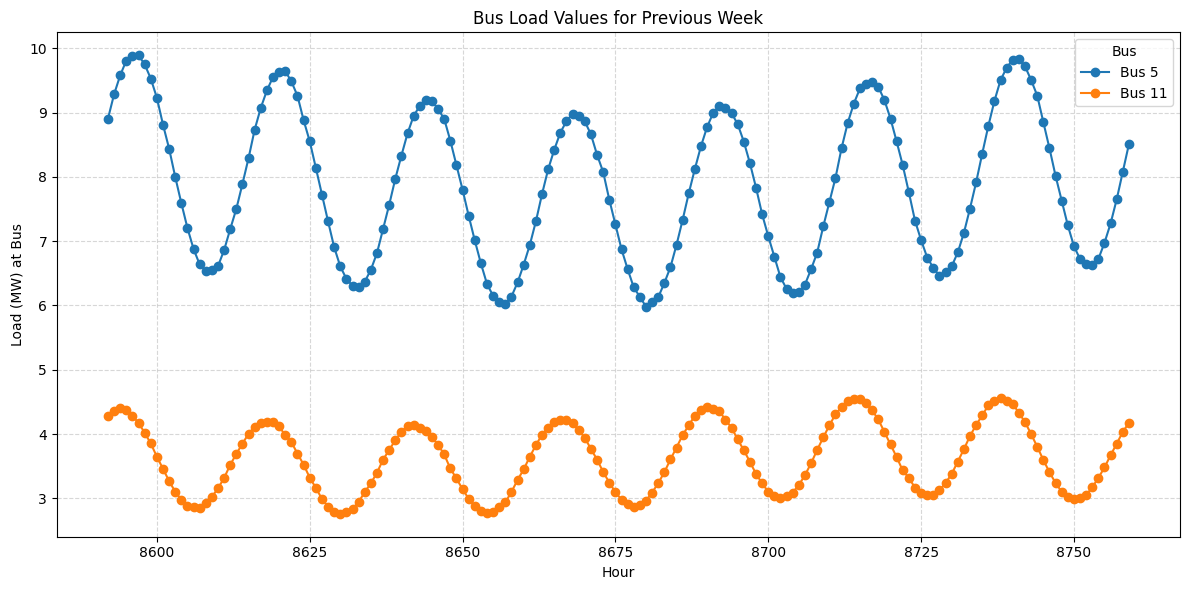

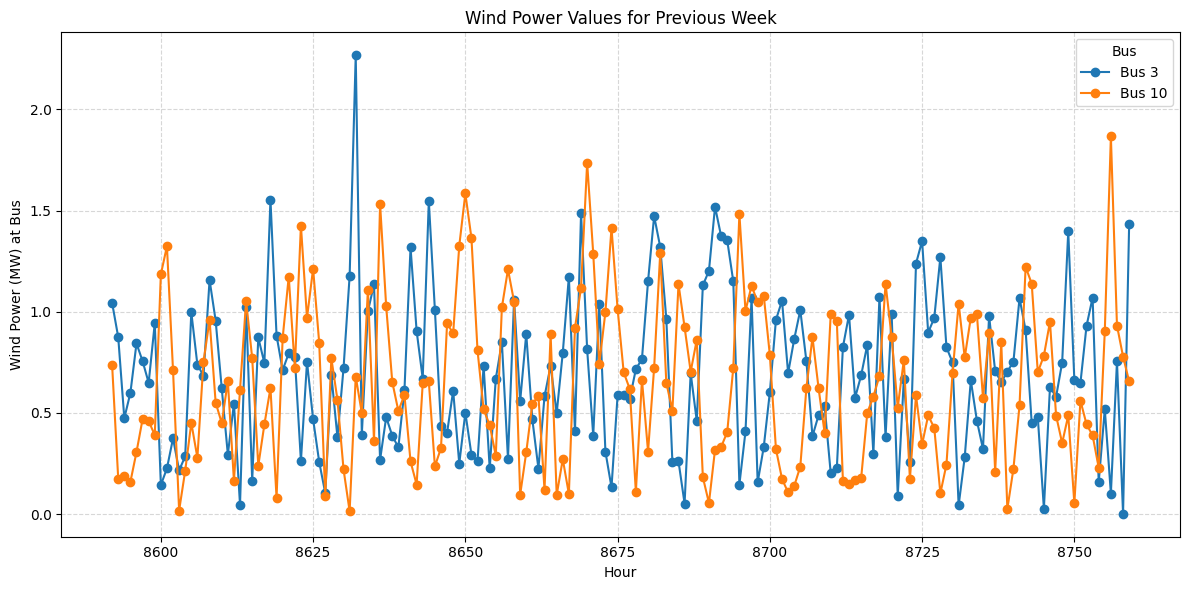

Generated synthetic historical load for 14 buses and wind history arrays


In [7]:
rng = np.random.RandomState(1234)
T_hist = 365 * 24  # one year hourly
bus_hist = {b: None for b in range(nb)}

# build baseline load per bus from net.bus p_mw attributes if present
base_load = np.zeros(nb)
if 'p_mw' in net.load.columns:
    # map loads to buses (some buses have multiple loads) — aggregate
    load_df = net.load.copy()
    for b in range(nb):
        base_load[b] = load_df[load_df.bus == b]['p_mw'].sum() if (load_df.bus==b).any() else 5.0
else:
    base_load = np.maximum(5.0 + 5.0 * np.sin(np.linspace(0, 2*np.pi, nb)), 1.0)

for b in range(nb):
    # seasonal daily + weekly + random variations
    t = np.arange(T_hist)
    daily = 1.0 + 0.2 * np.sin(2*np.pi*(t % 24)/24.0 + 0.1*b)
    weekly = 1.0 + 0.05 * np.sin(2*np.pi*(t % (24*7))/(24*7) + 0.2*b)
    trend = 1.0 + 0.0001 * (t/24.0)
    noise = 0.05 * rng.randn(T_hist)
    series = np.maximum(base_load[b] * daily * weekly * trend + base_load[b]*0.05 * noise, 0.0)
    bus_hist[b] = series
    
buses_to_plot = [4, 10]   
plt.figure(figsize=(12, 6))
for b in buses_to_plot:
    plt.plot(np.arange(T_hist)[-168:], bus_hist[b][-168:], marker='o', label=f"Bus {b+1}")
plt.title(f"Bus Load Values for Previous Week")
plt.xlabel("Hour")
plt.ylabel("Load (MW) at Bus")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Bus")
plt.tight_layout()
plt.show()

# build synthetic wind per bus (small) — assume wind limited to subset of buses (bus # 3 and 10)
wind_buses = [2, 9]
wind_hist = {b: np.maximum(0.0, 2.0 * np.abs(0.5 * np.sin(2*np.pi*(np.arange(T_hist) % 24)/24.0 + 0.3*b) + 0.2 * np.random.randn(T_hist))) for b in wind_buses}

plt.figure(figsize=(12, 6))
for b in wind_buses:
    plt.plot(np.arange(T_hist)[-168:], wind_hist[b][-168:], marker='o', label=f"Bus {b+1}")
plt.title(f"Wind Power Values for Previous Week")
plt.xlabel("Hour")
plt.ylabel("Wind Power (MW) at Bus")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Bus")
plt.tight_layout()
plt.show()

print('Generated synthetic historical load for', nb, 'buses and wind history arrays')

## 5. LSTM model definition and toy training per-bus

We define a small LSTM and run a short toy training loop for each bus using the synthetic historical series created above. For speed we keep training light — this produces plausible forecasts for the next 24 hours.

In [8]:
class SmallLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, out_len=24):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_len)
    def forward(self, x):
        # x shape: (batch, seq_len, 1)
        out, _ = self.lstm(x)
        h = out[:, -1, :]
        return self.fc(h)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


### Data preparation for LSTM (sliding windows)
We build sequences of length `seq_len` and predict next `H=24` hours.

In [10]:
seq_len = 168  # use last week as input
H = 24
batch_size = 64
epochs = 6  # short for toy run; increase for real training

def make_dataset(series, seq_len=seq_len, H=H):
    X = []
    Y = []
    L = len(series)
    for i in range(0, L - seq_len - H, 24):  # step by 24 for speed
        x = series[i:i+seq_len]
        y = series[i+seq_len:i+seq_len+H]
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# quick standardization per-bus
scalers = {}
for b in range(nb):
    scalers[b] = StandardScaler()
    data = bus_hist[b].reshape(-1,1)
    scalers[b].fit(data)

models = {}
forecasts = {}
for b in range(nb):
    series = bus_hist[b]
    X, Y = make_dataset(series)
    if len(X) < 4:
        # fallback naive forecast: repeat last day
        forecasts[b] = series[-24:].copy()
        models[b] = None
        continue
    # scale
    Xs = scalers[b].transform(X.reshape(-1,1)).reshape(X.shape)
    Ys = scalers[b].transform(Y.reshape(-1,1)).reshape(Y.shape)
    Xs = Xs[..., np.newaxis].astype(np.float32)
    Ys = Ys.astype(np.float32)
    # train small LSTM
    model = SmallLSTM(input_size=1, hidden_size=32, num_layers=1, out_len=H).to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    # simple training loop
    for ep in range(epochs):
        idxs = np.arange(Xs.shape[0])
        np.random.shuffle(idxs)
        for i in range(0, len(idxs), batch_size):
            batch_idx = idxs[i:i+batch_size]
            xb = torch.tensor(Xs[batch_idx]).to(device)
            yb = torch.tensor(Ys[batch_idx]).to(device)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            opt.step()
    # produce forecast using last seq_len hours
    last_seq = series[-seq_len:]
    last_scaled = scalers[b].transform(last_seq.reshape(-1,1)).reshape(1,seq_len,1).astype(np.float32)
    with torch.no_grad():
        pred_scaled = model(torch.tensor(last_scaled).to(device)).cpu().numpy().ravel()
    pred = scalers[b].inverse_transform(pred_scaled.reshape(-1,1)).ravel()
    forecasts[b] = np.maximum(pred, 0.0)
    models[b] = model
    print(f'Bus {b}: trained LSTM and produced 24h forecast (min {forecasts[b].min():.2f}, max {forecasts[b].max():.2f})')

print('LSTM forecasts prepared for all buses (toy training).')

# quick standardization per-bus
wind_scalers = {}
for b in wind_buses:
    wind_scalers[b] = StandardScaler()
    data = wind_hist[b].reshape(-1,1)
    wind_scalers[b].fit(data)

wind_models = {}
wind_forecasts = {}
for b in wind_buses:
    series = wind_hist[b]
    X, Y = make_dataset(series)
    if len(X) < 4:
        # fallback naive forecast: repeat last day
        wind_forecasts[b] = series[-24:].copy()
        wind_models[b] = None
        continue
    # scale
    Xs = wind_scalers[b].transform(X.reshape(-1,1)).reshape(X.shape)
    Ys = wind_scalers[b].transform(Y.reshape(-1,1)).reshape(Y.shape)
    Xs = Xs[..., np.newaxis].astype(np.float32)
    Ys = Ys.astype(np.float32)
    # train small LSTM
    wind_model = SmallLSTM(input_size=1, hidden_size=32, num_layers=1, out_len=H).to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    # simple training loop
    for ep in range(epochs):
        idxs = np.arange(Xs.shape[0])
        np.random.shuffle(idxs)
        for i in range(0, len(idxs), batch_size):
            batch_idx = idxs[i:i+batch_size]
            xb = torch.tensor(Xs[batch_idx]).to(device)
            yb = torch.tensor(Ys[batch_idx]).to(device)
            opt.zero_grad()
            out = wind_model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            opt.step()
    # produce forecast using last seq_len hours
    last_seq = series[-seq_len:]
    last_scaled = wind_scalers[b].transform(last_seq.reshape(-1,1)).reshape(1,seq_len,1).astype(np.float32)
    with torch.no_grad():
        pred_scaled = wind_model(torch.tensor(last_scaled).to(device)).cpu().numpy().ravel()
    pred = wind_scalers[b].inverse_transform(pred_scaled.reshape(-1,1)).ravel()
    wind_forecasts[b] = np.maximum(pred, 0.0)
    wind_models[b] = wind_model
    print(f'Wind Turbine @ Bus {b}: trained LSTM and produced 24h forecast (min {wind_forecasts[b].min():.2f}, max {wind_forecasts[b].max():.2f})')


Bus 0: trained LSTM and produced 24h forecast (min 4.41, max 5.77)
Bus 1: trained LSTM and produced 24h forecast (min 19.23, max 24.82)
Bus 2: trained LSTM and produced 24h forecast (min 80.90, max 111.09)
Bus 3: trained LSTM and produced 24h forecast (min 42.81, max 53.39)
Bus 4: trained LSTM and produced 24h forecast (min 6.28, max 9.06)
Bus 5: trained LSTM and produced 24h forecast (min 9.90, max 12.59)
Bus 6: trained LSTM and produced 24h forecast (min 4.33, max 6.04)
Bus 7: trained LSTM and produced 24h forecast (min 4.37, max 5.93)
Bus 8: trained LSTM and produced 24h forecast (min 23.01, max 35.08)
Bus 9: trained LSTM and produced 24h forecast (min 8.31, max 10.28)
Bus 10: trained LSTM and produced 24h forecast (min 3.33, max 3.91)
Bus 11: trained LSTM and produced 24h forecast (min 5.64, max 6.89)
Bus 12: trained LSTM and produced 24h forecast (min 11.43, max 15.47)
Bus 13: trained LSTM and produced 24h forecast (min 13.61, max 17.41)
LSTM forecasts prepared for all buses (toy 

## 6. Monte-Carlo sampling around forecasts and K-means reduction to scenarios

We generate many perturbed trajectories around the LSTM mean forecasts and reduce them to `K` representative scenarios with KMeans.

In [12]:
N_mc = 300
rng = np.random.RandomState(42)
samples = []
for s in range(N_mc):
    samp = {b: None for b in range(nb)}
    for b in range(nb):
        mean = forecasts[b]
        # estimate residual std from historical last week
        resid = bus_hist[b][-7*24:] - np.tile(bus_hist[b][-24:], 7)
        sigma = max(0.5, np.std(resid))
        noise = rng.randn(H) * 0.5 * sigma
        samp[b] = np.maximum(mean + noise, 0.0)
    samples.append(samp)
    
# Repeat for the wind history
wind_samples = []
for s in range(N_mc):
    wind_samp = {b: None for b in wind_buses}
    for b in wind_buses:
        mean = wind_forecasts[b]
        # estimate residual std from historical last week
        resid = wind_hist[b][-7*24:] - np.tile(wind_hist[b][-24:], 7)
        sigma = max(0.5, np.std(resid))
        noise = rng.randn(H) * 0.5 * sigma
        wind_samp[b] = np.maximum(mean + noise, 0.0)
    wind_samples.append(wind_samp)

# vectorize for kmeans: concatenate bus traces
vecs = np.array([
    np.concatenate(
        [samples[s][b] for b in range(nb)] +
        [wind_samples[s][b] for b in wind_buses]
    )
    for s in range(N_mc)
])
K = min(20, N_mc // 10)
kmeans = KMeans(n_clusters=K, random_state=0).fit(vecs)
centers = kmeans.cluster_centers_
scenarios = {}
wind_scenarios = {}
for i in range(K):
    c = centers[i]
    idx = np.argmin(np.linalg.norm(vecs - c, axis=1))
    scenarios[i] = samples[idx]
    wind_scenarios[i] = wind_samples[idx]
Sred = list(scenarios.keys())
pi = {s: 1.0/len(Sred) for s in Sred}
print('Reduced to', len(Sred), 'scenarios')


Reduced to 20 scenarios


### 6.1. Aggregate per-scenario total load and total wind (system-level, used in some dispatch approximations)
We also keep per-bus loads in `scenarios` for DC nodal constraints.

In [13]:
scenario_total_load = {s: {t: sum(float(scenarios[s][b][t]) for b in range(nb)) for t in range(H)} for s in Sred}
scenario_total_wind = {s: {t: sum(float(wind_scenarios[s][b][t]) for b in wind_buses) for t in range(H)} for s in Sred}  
print(f'Sample total load for scenario 0 @ t0 is {scenario_total_load[Sred[0]][0]:.2f} MW')
print(f'Sample total wind power for scenario 0 @ t0 is {scenario_total_wind[Sred[0]][0]:.2f} MW')

Sample total load for scenario 0 @ t0 is 300.08 MW
Sample total wind power for scenario 0 @ t0 is 1.64 MW


## 7. UC parameters (4 generators) and mapping to buses
We define the generator parameters and map the 4 generators to specific IEEE-14 buses. You can change `gen_bus` mapping to match the true IEEE-14 generator locations if needed.

In [14]:
# Horizon
T = list(range(H))

G_list = ['U1','U2','U3','U4']
Pmax = {'U1': 120.0, 'U2': 80.0, 'U3': 150.0, 'U4': 60.0}
Pmin = {'U1': 20.0,  'U2': 10.0, 'U3': 40.0,  'U4': 5.0}
SU = {'U1': 800.0,'U2': 400.0,'U3': 1200.0, 'U4':400.0}
RU = {'U1': 40.0, 'U2': 30.0, 'U3': 50.0, 'U4': 20.0}
RD = {'U1': 40.0, 'U2': 30.0,'U3': 50.0, 'U4': 20.0}
startup_cost = SU.copy()
var_cost = {'U1': 20.0,  'U2': 24.0,  'U3': 18.0,  'U4': 30.0}

# Map gens to buses (choose plausible generator bus indices for IEEE-14)
gen_bus = {'U1': 0, 'U2': 2, 'U3': 7, 'U4': 11}

# Map wind turbines to buses
wind_bus = {'WT1': 2, 'WT2': 9}

# initial on/off state before t=0
u_initial = {g: 1 for g in G_list}  # start all online to be safe

print("UC parameters created. Generator → Bus mapping:")
for g, b in gen_bus.items():
    print(f"  Generator {g} mapped to bus {b}")
    
print("UC parameters created. Wind Turbine → Bus mapping:")
for g, b in wind_bus.items():
    print(f"  Wind Turbine {g} mapped to bus {b}")


UC parameters created. Generator → Bus mapping:
  Generator U1 mapped to bus 0
  Generator U2 mapped to bus 2
  Generator U3 mapped to bus 7
  Generator U4 mapped to bus 11
UC parameters created. Wind Turbine → Bus mapping:
  Wind Turbine WT1 mapped to bus 2
  Wind Turbine WT2 mapped to bus 9


## 8. DC-OPF subproblem builder (Pyomo LP) using PTDF

This builder returns a Pyomo ConcreteModel representing the per-scenario dispatch problem with fixed integer $u$. It imports duals using the `Suffix` object so we can extract multipliers for Benders cuts.

In [15]:
def select_lp_solver():
    # prefer glpk or cbc for LP duals; if not present use any available
    for s in ('glpk', 'cbc', 'gurobi', 'cplex'):
        try:
            if pyo.SolverFactory(s).available():
                return pyo.SolverFactory(s)
        except Exception:
            pass
    raise RuntimeError('No LP solver available (glpk/cbc/gurobi/cplex required)')

lp_solver = select_lp_solver()
print('LP solver selected:', lp_solver.name)


LP solver selected: glpk


In [16]:
import numpy as np
import pandas as pd

def get_line_mw_limits(net, default_limit_mw=1e9):
    """
    Convert pandapower line current limits (max_i_ka) into MW thermal limits
    usable in a DC power flow or DC OPF model.

    Parameters:
    -----------
    net : pandapowerNet
        The pandapower network model containing bus and line data.
    
    default_limit_mw : float
        Fallback thermal limit in MW if max_i_ka is missing.

    Returns:
    --------
    line_limits : dict
        Dictionary mapping line index -> MW thermal limit.
    """

    line_limits = {}

    lines_df = net.line.reset_index()

    for _, row in lines_df.iterrows():
        line_idx = int(row["index"])

        # 1. Check if current limit exists
        if "max_i_ka" in row and not pd.isna(row["max_i_ka"]):
            i_max = float(row["max_i_ka"])                # kA
        else:
            line_limits[line_idx] = default_limit_mw
            continue

        # 2. Get the nominal voltage (kV) of the FROM bus
        from_bus = row["from_bus"]
        v_nom = net.bus.loc[from_bus, "vn_kv"]           # kV

        # 3. Convert 3-phase apparent power limit (kVA) → MW
        #    S_max = sqrt(3) * V_LL (kV) * I (kA)
        s_max_mva = np.sqrt(3) * v_nom * i_max          # MVA
        p_max_mw = s_max_mva                            # in DC OPF: P \approx S

        line_limits[line_idx] = p_max_mw

    return line_limits

def compute_startups(u, u_init, G_list, T_list):
    """
    Computes startup variable y[g,t] from commitment u[g,t]
    and initial commitment u_init[g].

    Parameters:
        u       : dict {(g,t): 0/1}   commitment schedule
        u_init  : dict {g: 0/1}       initial on/off state
        G_list  : list of generators
        T_list  : list of time indices (e.g. 0..23)

    Returns:
        y : dict {(g,t): 0/1} startup indicator
    """

    y = {}

    for g in G_list:
        for t in T_list:
            if t == T_list[0]:
                # First time step: compare to initial state
                y[(g, t)] = max(0, u[(g, t)] - u_init[g])
            else:
                # Compare to previous time step
                y[(g, t)] = max(0, u[(g, t)] - u[(g, T_list[T_list.index(t) - 1])])

    return y

def build_dc_subproblem_with_ptdf(u_k, u_init, s, include_line_limits=True, bigM_shed=1e5):
    """
    Build a per-scenario LP with fixed integer decisions u_k (dict (g,t) -> 0/1).
    Uses PTDF (global variable) and scenarios (global) to impose nodal balance and line limits.
    Returns a ConcreteModel with dual suffix attached.
    """
    # Compute y_fixed from u_fixed
    y_fixed = compute_startups(u_k, u_init, G_list, T)
    
    m = pyo.ConcreteModel()
    m.G = pyo.Set(initialize=G_list)
    m.T = pyo.Set(initialize=T)
    m.B = pyo.Set(initialize=list(range(nb)))
    m.L = pyo.Set(initialize=list(range(nlines)))
    # variables
    m.p = pyo.Var(m.G, m.T, domain=pyo.NonNegativeReals)
    m.shed_bus = pyo.Var(m.B, m.T, domain=pyo.NonNegativeReals)
    m.f = pyo.Var(m.L, m.T, domain=pyo.Reals)  # line flows
    # objective: generation cost + large shedding penalty
    m.obj = pyo.Objective(expr=sum(var_cost[g]*m.p[g,t] for g in m.G for t in m.T) + sum(SU[g]*y_fixed[(g,t)] for g in m.G for t in m.T) + bigM_shed * sum(m.shed_bus[b,t] for b in m.B for t in m.T), sense=pyo.minimize)
    # capacity coupling (u_k fixed)
    def cap_rule(m,g,t):
        return m.p[g,t] <= Pmax[g] * float(u_k[(g,t)])
    m.cap = pyo.Constraint(m.G, m.T, rule=cap_rule)
    def minp_rule(m,g,t):
        return m.p[g,t] >= Pmin[g] * float(u_k[(g,t)])
    m.minp = pyo.Constraint(m.G, m.T, rule=minp_rule)
    # nodal injection: inj_b = sum_g at bus b p_g - load_b + wind_b + shed_b
    def inj_expr(m, b, t):
        gen_term = sum(m.p[g,t] for g in m.G if gen_bus[g] == b)
        load_bt = float(scenarios[s][b][t]) if b in scenarios[s] else 0.0
        wind_bt = float(wind_scenarios[s][b][t]) if b in wind_buses and b in scenarios[s] else 0.0
        return gen_term - load_bt + wind_bt + m.shed_bus[b,t]
    # link flows via PTDF: f_l = sum_b PTDF[l,b] * inj_b
    def flow_def_rule(m,l,t):
        return m.f[l,t] == sum(float(PTDF[l,b]) * inj_expr(m,b,t) for b in range(nb))
    m.flow_def = pyo.Constraint(m.L, m.T, rule=flow_def_rule)
    def bus_balance(m, t):
        return sum(inj_expr(m, b, t) for b in m.B) == 0
    m.balance = pyo.Constraint(m.T, rule=bus_balance)
    # line thermal limits: get a bound from net.line
    line_limits = get_line_mw_limits(net)
    if include_line_limits:
        m.line_ub = pyo.Constraint(m.L, m.T, rule=lambda m,l,t: m.f[l,t] <= line_limits[l])
        m.line_lb = pyo.Constraint(m.L, m.T, rule=lambda m,l,t: -line_limits[l] <= m.f[l,t])
    # bus balance implicit through PTDF and flow_def ensures power conservation; but ensure overall consistency
    # Add optional system-level balance check (redundant if PTDF consistent)
    # duals
    m.dual = Suffix(direction=Suffix.IMPORT)
    return m

def build_feasibility_elastic_subproblem(u_k, u_init, s, include_line_limits=True, bigM_shed=1e5):
    """
    Build a per-scenario LP with fixed integer decisions u_k (dict (g,t) -> 0/1).
    Uses PTDF (global variable) and scenarios (global) to impose nodal balance and line limits.
    Returns a ConcreteModel with dual suffix attached.
    """
    # Compute y_fixed from u_fixed
    y_fixed = compute_startups(u_k, u_init, G_list, T)
    
    m = pyo.ConcreteModel()
    m.G = pyo.Set(initialize=G_list)
    m.T = pyo.Set(initialize=T)
    m.B = pyo.Set(initialize=list(range(nb)))
    m.L = pyo.Set(initialize=list(range(nlines)))
    # variables
    m.p = pyo.Var(m.G, m.T, domain=pyo.NonNegativeReals)
    m.shed_bus = pyo.Var(m.B, m.T, domain=pyo.NonNegativeReals)
    m.f = pyo.Var(m.L, m.T, domain=pyo.Reals)  # line flows
    m.pos_slack = pyo.Var(m.B, m.T, domain=pyo.NonNegativeReals)
    m.neg_slack = pyo.Var(m.B, m.T, domain=pyo.NonNegativeReals)
    
    # objective: generation cost + large shedding penalty
    m.obj = pyo.Objective(expr=sum(m.pos_slack[b,t] + m.neg_slack[b,t] for b in m.B for t in m.T), sense=pyo.minimize)
    # capacity coupling (u_k fixed)
    def cap_rule(m,g,t):
        return m.p[g,t] <= Pmax[g] * float(u_k[(g,t)])
    m.cap = pyo.Constraint(m.G, m.T, rule=cap_rule)
    def minp_rule(m,g,t):
        return m.p[g,t] >= Pmin[g] * float(u_k[(g,t)])
    m.minp = pyo.Constraint(m.G, m.T, rule=minp_rule)
    # nodal injection: inj_b = sum_g at bus b p_g - load_b + wind_b + shed_b
    def inj_expr(m, b, t):
        gen_term = sum(m.p[g,t] for g in m.G if gen_bus[g] == b)
        load_bt = float(scenarios[s][b][t]) if b in scenarios[s] else 0.0
        wind_bt = float(wind_scenarios[s][b][t]) if b in wind_buses and b in scenarios[s] else 0.0
        return gen_term - load_bt + wind_bt + m.shed_bus[b,t] + m.pos_slack[b,t] - + m.neg_slack[b,t]
    # link flows via PTDF: f_l = sum_b PTDF[l,b] * inj_b
    def flow_def_rule(m,l,t):
        return m.f[l,t] == sum(float(PTDF[l,b]) * inj_expr(m,b,t) for b in range(nb))
    m.flow_def = pyo.Constraint(m.L, m.T, rule=flow_def_rule)
    def bus_balance(m, t):
        return sum(inj_expr(m, b, t) for b in m.B) == 0
    m.balance = pyo.Constraint(m.T, rule=bus_balance)
    # line thermal limits: get a bound from net.line
    line_limits = get_line_mw_limits(net)
    if include_line_limits:
        m.line_ub = pyo.Constraint(m.L, m.T, rule=lambda m,l,t: m.f[l,t] <= line_limits[l])
        m.line_lb = pyo.Constraint(m.L, m.T, rule=lambda m,l,t: -line_limits[l] <= m.f[l,t])
    # bus balance implicit through PTDF and flow_def ensures power conservation; but ensure overall consistency
    # Add optional system-level balance check (redundant if PTDF consistent)
    # duals
    m.dual = Suffix(direction=Suffix.IMPORT)
    return m

print('Models for DC subproblems defined.')

Models for DC subproblems defined.


## 9. Deterministic UC model (for validation) with min-up/min-down and DC constraints
This deterministic UC enforces min-up/min-down and DC constraints to validate candidate commitments or as a baseline benchmark.

In [19]:
def build_deterministic_uc(D_bus, W_bus, u_init, solve_mip=True, bigM_shed=1e5):
    """Build a full MIP UC over horizon T with bus-level DC constraints using PTDF.
    D_bus: dict b->array of length T (loads)
    W_bus: dict b->array of length T (wind)
    u_init: dict g->0/1 initial state
    Returns (model, solver)"""
    m = pyo.ConcreteModel()
    m.G = pyo.Set(initialize=G_list); m.T = pyo.Set(initialize=T); m.B = pyo.Set(initialize=list(range(nb))); m.L = pyo.Set(initialize=list(range(nlines)))
    # vars
    m.u = pyo.Var(m.G, m.T, domain=pyo.Binary)
    m.y = pyo.Var(m.G, m.T, domain=pyo.Binary)
    m.p = pyo.Var(m.G, m.T, domain=pyo.NonNegativeReals)
    m.shed_bus = pyo.Var(m.B, m.T, domain=pyo.NonNegativeReals)
    m.f = pyo.Var(m.L, m.T, domain=pyo.Reals)
    # objective: startup costs + generation variable costs + shedding
    m.obj = pyo.Objective(expr=sum(SU[g]*m.y[g,t] for g in m.G for t in m.T) + sum(var_cost[g]*m.p[g,t] for g in m.G for t in m.T) + bigM_shed * sum(m.shed_bus[b,t] for b in m.B for t in m.T), sense=pyo.minimize)
    # startup linking: y >= u_t - u_{t-1}
    def start_link(m,g,t):
        if t == 0:
            return m.y[g,t] >= m.u[g,t] - int(u_init[g])
        return m.y[g,t] >= m.u[g,t] - m.u[g,t-1]
    m.start = pyo.Constraint(m.G, m.T, rule=start_link)
    # cap/min
    m.cap = pyo.Constraint(m.G, m.T, rule=lambda m,g,t: m.p[g,t] <= Pmax[g] * m.u[g,t])
    m.minp = pyo.Constraint(m.G, m.T, rule=lambda m,g,t: m.p[g,t] >= Pmin[g] * m.u[g,t])
    # ramping
    def rup(m,g,t):
        if t == 0: return pyo.Constraint.Skip
        return m.p[g,t] - m.p[g,t-1] <= RU[g]
    def rdn(m,g,t):
        if t == 0: return pyo.Constraint.Skip
        return m.p[g,t-1] - m.p[g,t] <= RD[g]
    m.rup = pyo.Constraint(m.G, m.T, rule=rup)
    m.rdn = pyo.Constraint(m.G, m.T, rule=rdn)
    # nodal balance per bus using PTDF to get flows
    def bus_balance(m,b,t):
        gen_term = sum(m.p[g,t] for g in m.G if gen_bus[g] == b)
        load_bt = float(D_bus[b][t])
        wind_bt = float(W_bus[b][t]) if (b in W_bus) else 0.0
        inj = gen_term + wind_bt - load_bt + m.shed_bus[b,t]
        # represent flows via PTDF: sum_l PTDF[l,b]*inj_b = f_l; consistent with flow definitions
        return inj == 0
    m.balance = pyo.Constraint(m.B, m.T, rule=bus_balance)
    # flows via PTDF definition (optional) — for full DC constraints add these linking constraints
    # we'll add flow constraints analogous to flow_def in subproblem
    def flow_def(m,l,t):
        return m.f[l,t] == sum(float(PTDF[l,b]) * (sum(m.p[g,t] for g in m.G if gen_bus[g] == b) - float(D_bus[b][t]) + (float(W_bus[b][t]) if (b in W_bus) else 0.0) + m.shed_bus[b,t]) for b in range(nb))
    m.flow_def = pyo.Constraint(m.L, m.T, rule=flow_def)
    # line limits
    line_limits = get_line_mw_limits(net)
    # lines_df = net.line.reset_index()
    # line_limits = {}
    # for idx, row in lines_df.iterrows():
    #     line_limits[int(idx)] = float(row.get('max_i_ka', 1e9)) if ('max_i_ka' in row and not pd.isna(row['max_i_ka'])) else 1e9
    m.line_ub = pyo.Constraint(m.L, m.T, rule=lambda m,l,t: m.f[l,t] <= line_limits[l])
    m.line_lb = pyo.Constraint(m.L, m.T, rule=lambda m,l,t: -line_limits[l] <= m.f[l,t])
    # attach dual suffix for extraction if needed
    m.dual = Suffix(direction=Suffix.IMPORT)
    return m

print('Deterministic UC model defined.')


Deterministic UC model defined.


## 10. Quick checks: test subproblem feasibility for an all-on commitment and for u_initial
We test that the subproblem builder produces feasible LPs when units are ON according to `u_initial` or when a more conservative commitment is given.

In [20]:
# build a simple u_k: everyone ON for all hours
u_all_on = {(g,t): 1 for g in G_list for t in T}
u_all_off = {(g,t): 0 for g in G_list for t in T}
print('Testing subproblem feasibility for u_all_on for scenario 0')
try:
    sub0 = build_dc_subproblem_with_ptdf(u_all_on, u_initial, Sred[0])
    res = lp_solver.solve(sub0, tee=False)
    print('Subproblem u_all_on status:', res.solver.termination_condition)
except Exception as e:
    print('Subproblem build/solve error (u_all_on):', e)

print('Testing subproblem feasibility for u_all_off for scenario 0 (should be infeasible unless shedding allowed)')
try:
    sub1 = build_dc_subproblem_with_ptdf(u_all_off, u_initial, Sred[0])
    res1 = lp_solver.solve(sub1, tee=False)
    print('Subproblem u_all_off status:', res1.solver.termination_condition)
except Exception as e:
    print('Subproblem build/solve error (u_all_off):', e)

print('You should see u_all_on feasible (or feasible with shedding). If not, check problem setup.')


Testing subproblem feasibility for u_all_on for scenario 0
Subproblem u_all_on status: optimal
Testing subproblem feasibility for u_all_off for scenario 0 (should be infeasible unless shedding allowed)
Subproblem u_all_off status: optimal
You should see u_all_on feasible (or feasible with shedding). If not, check problem setup.


# 2. Progressive Hedging (PH) — theory & practical notes

PH is a scenario-decomposition method suitable for problems with **nonanticipative** first-stage decisions (like $u_{g,t}$) and scenario-specific second-stage decisions (like $p_{g,t,s}$). It solves the stochastic problem by alternating scenario subproblem solves with consensus updates using an augmented Lagrangian (quadratic) penalty.

## Stochastic two-stage formulation (expected cost)

Let scenarios $s\in S$ have probability $\pi_s$ and scenario data (loads etc.) $d_s$. The stochastic UC can be written as:
$$
\min_{u\in\mathcal U}; \sum_{s\in S} \pi_s Q_s(u)
$$
where $Q_s(u)$ is the minimal second-stage cost for scenario $s$ given first-stage decision $u$:
$$
Q_s(u) = \min_{x_s\in X_s(u)} c_s^\top x_s.
$$
Here $x_s$ denotes scenario-specific variables (dispatch $p_{g,t,s}$, flows, load shed, etc.). The nonanticipativity constraints are that the first-stage variables $u$ are identical across scenarios.

Instead of solving the large stochastic MIP as one big problem, PH relaxes nonanticipativity and enforces it via penalties.

## Augmented Lagrangian / PH subproblems

Introduce scenario-specific copies $u^{(s)}$ and enforce consensus $u^{(s)} = \bar u$ (where $\bar u$ is the consensus variable). PH solves, for each scenario $s$, the penalized subproblem:

$$
\min_{u^{(s)},x_s} c_s^\top x_s
+ \lambda_s^\top (u^{(s)} - \bar u) + \frac{\rho}{2} |u^{(s)} - \bar u|_2^2
$$

(we can add penalties on both $u$ and continuous first-stage variables, e.g. $p$ if they are treated nonanticipative).

Concretely, for our UC with both $u$ and $p$ encouraged to agree across scenarios, the per-scenario objective is:

$$
\min_{u^{(s)},p^{(s)},\ldots}
 \underbrace{\sum_{t,g} C_g^{\text{var}} p^{(s)}_{g,t} + \sum_{t,g} SU_g y^{(s)}_{g,t} + M_{\text{shed}}\sum_{b,t} sh^{(s)}_{b,t}}_{\text{standard c}_s^\top x_s}
+ \sum_{g,t} \lambda^u_{s,g,t} (u^{(s)}_{g,t}-\bar u_{g,t}) + \frac{\rho_u}{2}\sum_{g,t}(u^{(s)}_{g,t}-\bar u_{g,t})^2
+ \sum_{g,t} \lambda^p_{s,g,t} (p^{(s)}_{g,t}-\bar p_{g,t}) + \frac{\rho_p}{2}\sum_{g,t}(p^{(s)}_{g,t}-\bar p_{g,t})^2
  $$

**Why penalize $p$ too?** If $p$ is allowed to vary freely across scenarios while $u$ is the only consensus variable, then scenario dispatchs can be wildly different and $u$ consensus may be harder to enforce numerically. Penalizing $p$ (or other linking continuous variables) often improves convergence.

## PH algorithm (classical)

Initialize $\bar u$ (e.g. from a heuristic or zeros) and multipliers $\lambda^u_s = 0$.

Repeat until convergence:

1. **Scenario step**: For each $s$, solve the penalized subproblem to obtain $u^{(s)}$ and $p^{(s)}$. (Often the integer constraint on $u^{(s)}$ is relaxed to $[0,1]$ in PH to get a continuous QP; alternatively solve as MIP but then PH can be slow.)

2. **Consensus update**:
   $$
   \bar u_{g,t} \leftarrow \sum_{s} \pi_s u^{(s)}_{g,t},\qquad
   \bar p_{g,t} \leftarrow \sum_s \pi_s p^{(s)}_{g,t}.
   $$

3. **Multiplier update**:
   $$
   \lambda^u_{s,g,t} \leftarrow \lambda^u_{s,g,t} + \rho_u(u^{(s)}_{g,t} - \bar u_{g,t}),\qquad
   \lambda^p_{s,g,t} \leftarrow \lambda^p_{s,g,t} + \rho_p(p^{(s)}_{g,t} - \bar p_{g,t}).
   $$

4. **Check convergence**: e.g., compute
   $$
   \max_{g,t} \max_s |u^{(s)}_{g,t} - \bar u_{g,t}|
   $$
   and stop when below tolerance.

5. **Integerization**: When PH converges on the relaxed (continuous) problem, produce an integer solution for $u$: common strategies are simple rounding, thresholding, or solving a small MILP to find the integer $u$ that is closest to $\bar u$ subject to UC constraints (min-up/dn, ramp) — this often gives much better final solutions.

**Augmented Lagrangian interpretation**: PH solves the augmented Lagrangian decomposition, which for convex problems (continuous) converges to optimal; for nonconvex problems (like MIP) PH is a heuristic that often provides good feasible solutions.

**Practical tips**

* Choose $\rho$ scale comparable to costs: if $\rho$ is too small, scenarios stray; if too large, the quadratic dominates and numerical issues occur. Typical strategy: start with modest $\rho$ and increase adaptively.
* Penalize both discrete and continuous linking variables when relevant.
* Use relaxed integrality (continuous $[0,1]$) for speed, but keep in mind rounding and feasibility afterwards.
* Include startup linking with correct $u^{\text{init}}$ to ensure realistic startup behavior at $t=0$.

PH iter 0
 max_dev = 8.146816036869176e-05
PH converged


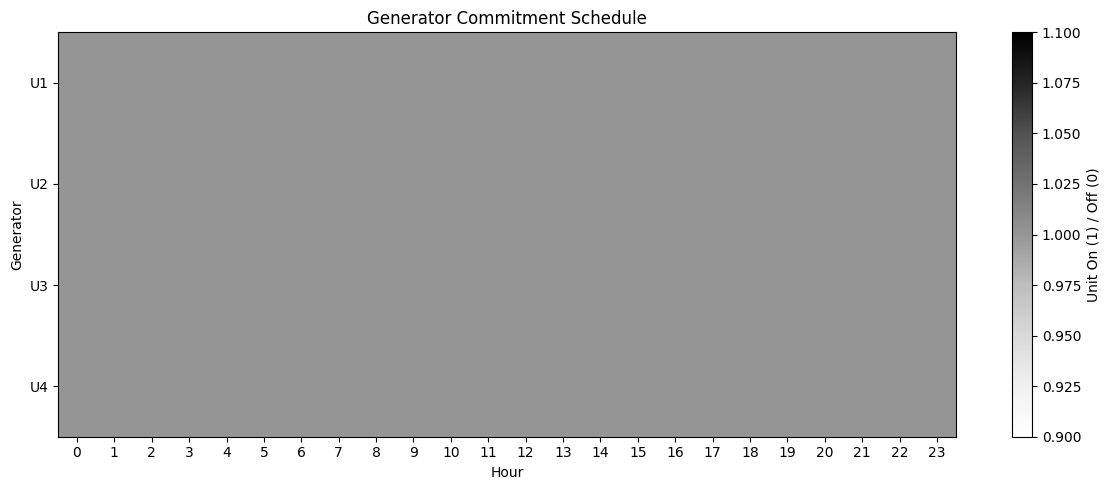

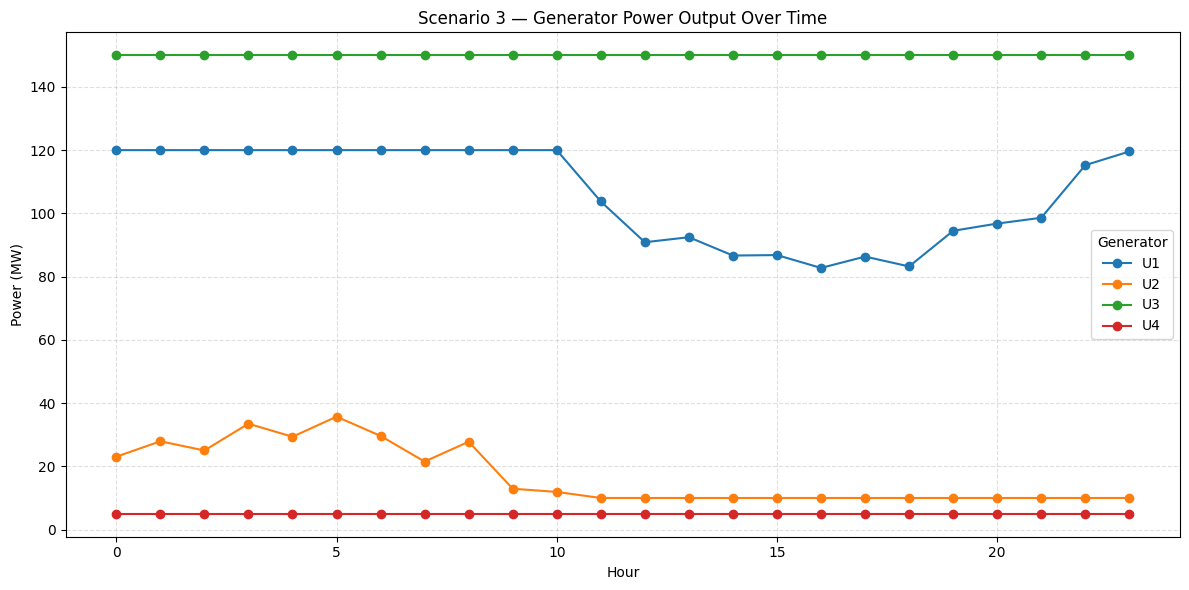

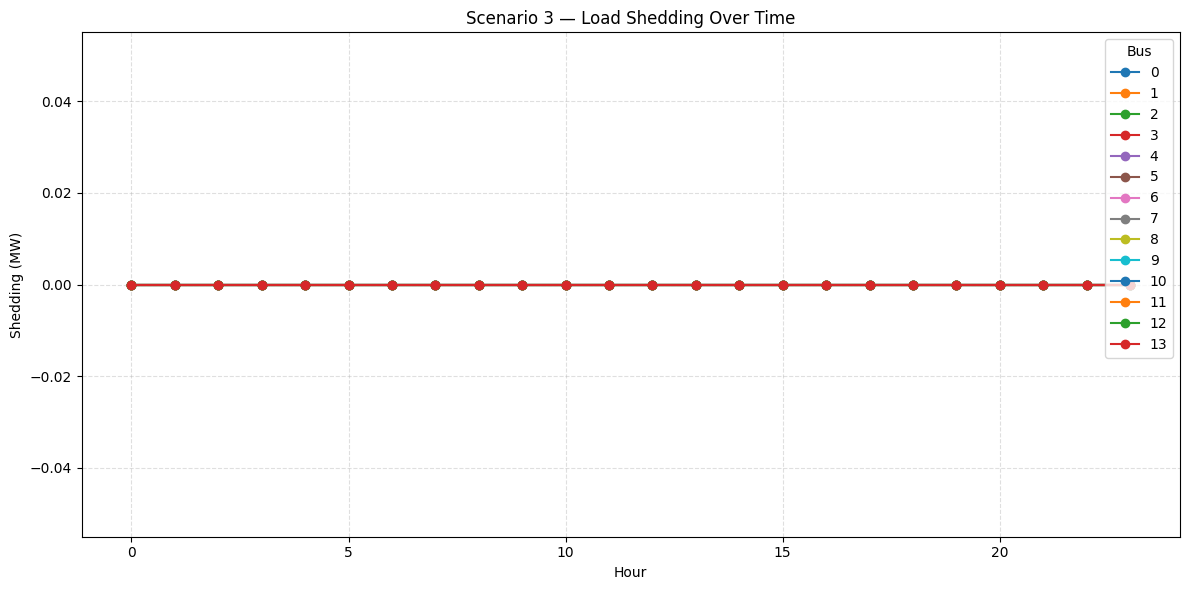

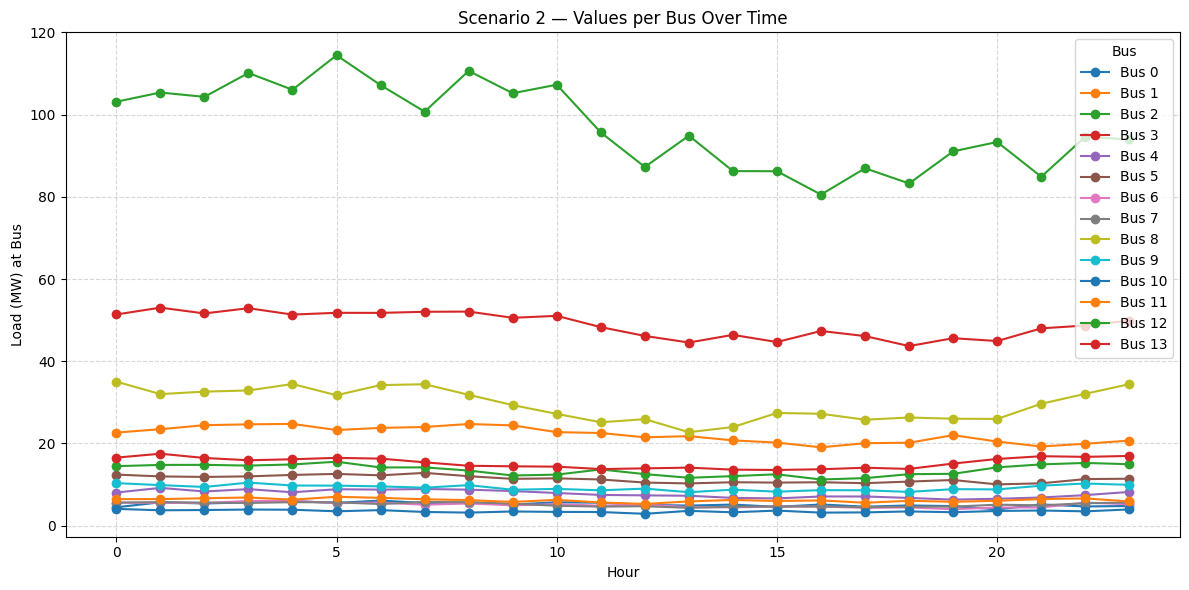

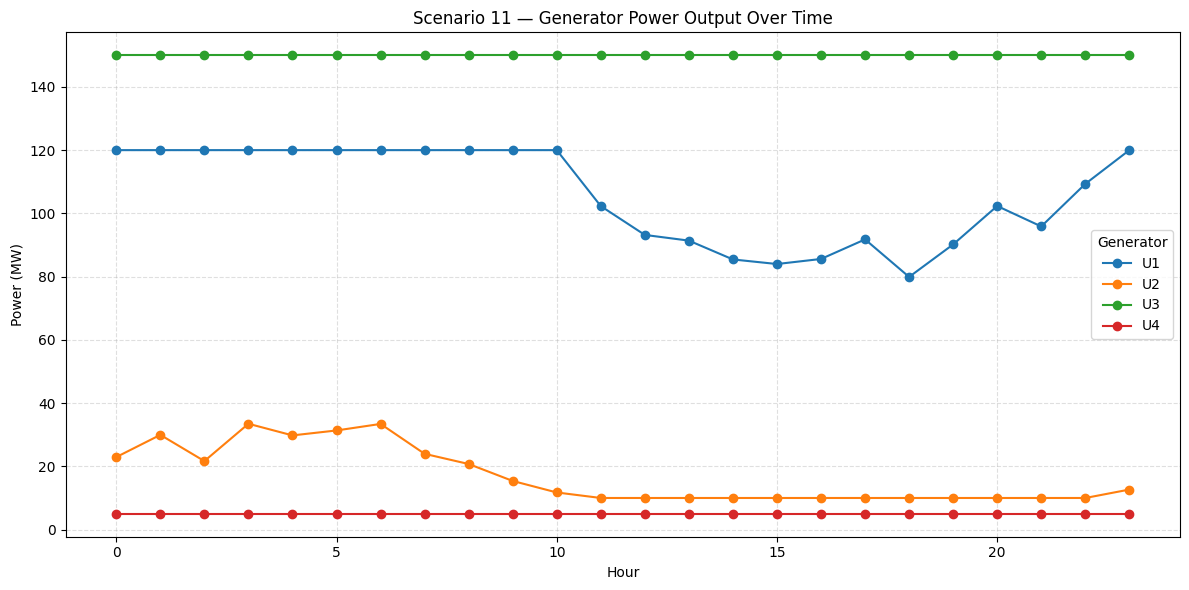

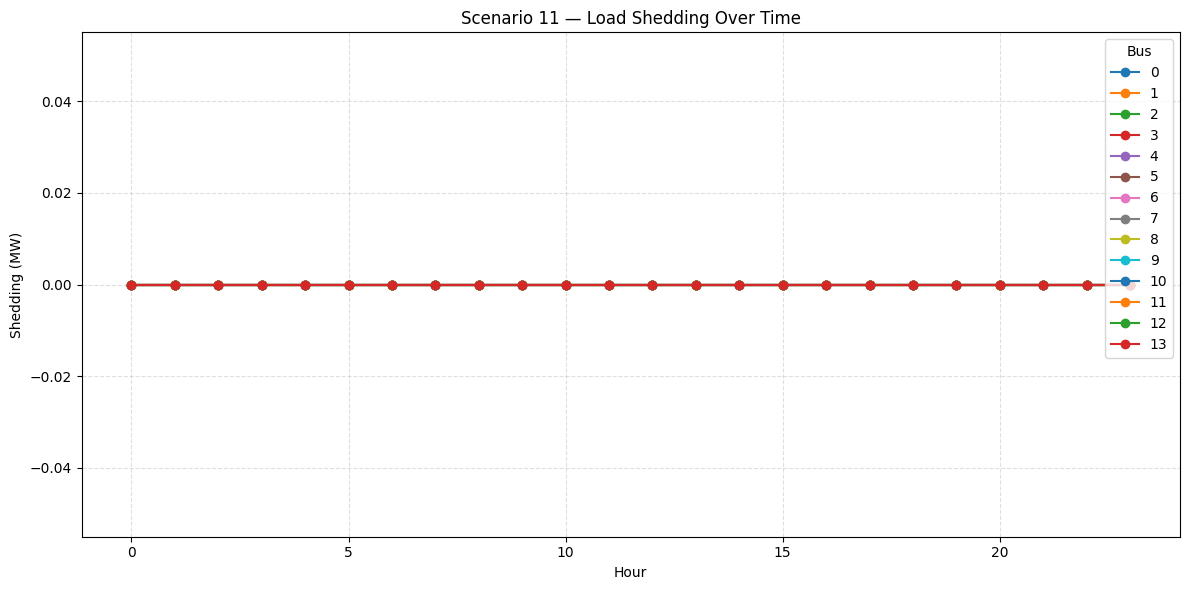

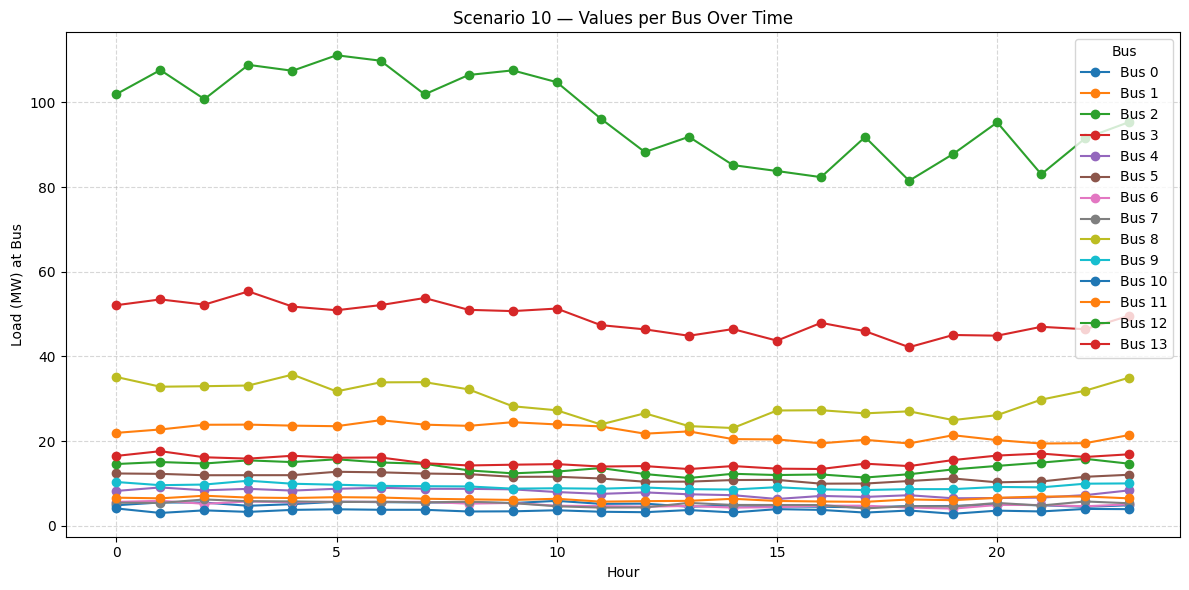

Final expected cost (approx) with PH = 129053.20
Max dev for PH = 8.15E-05


In [23]:
# PH hyperparameters (tune as needed)
rho_u = 1000.0
rho_p = 200.0
max_ph_iter = 200
tol_ph = 1e-3
M_shed = 1e5

# initialize consensus and multipliers
bar_u = {(g,t): float(u_initial[g]) for g in G_list for t in T}
bar_p = {(g,t): 0.0 for g in G_list for t in T}
lam_u = {s: {(g,t): 0.0 for g in G_list for t in T} for s in Sred}
lam_p = {s: {(g,t): 0.0 for g in G_list for t in T} for s in Sred}

# helper: build PH scenario model (QP) using Pyomo; requires QP-capable solver (ipopt handles nonlinear quadratic penalties)
def build_ph_scenario_qp(s, bar_u, bar_p, lam_u_s, lam_p_s):
    m = pyo.ConcreteModel()
    m.G = pyo.Set(initialize=G_list); m.T = pyo.Set(initialize=T); m.B = pyo.Set(initialize=list(range(nb)))
    # relaxed u in [0,1]
    m.u = pyo.Var(m.G, m.T, bounds=(0.0,1.0))
    m.y = pyo.Var(m.G, m.T, bounds=(0.0,1.0))  # startup surrogate
    m.p = pyo.Var(m.G, m.T, domain=pyo.NonNegativeReals)
    m.shed_bus = pyo.Var(m.B, m.T, domain=pyo.NonNegativeReals)
    m.f = pyo.Var(range(nlines), m.T, domain=pyo.Reals)
    # objective: generation + startup surrogate + shed + PH penalties
    def obj_rule(m):
        gen_cost = sum(var_cost[g]*m.p[g,t] for g in m.G for t in m.T)
        start_cost = sum(SU[g]*m.y[g,t] for g in m.G for t in m.T)
        shed_cost = M_shed * sum(m.shed_bus[b,t] for b in m.B for t in m.T)
        ph_u = sum(float(lam_u_s[(g,t)])*(m.u[g,t]-bar_u[(g,t)]) + 0.5*rho_u*(m.u[g,t]-bar_u[(g,t)])**2 for g in G_list for t in T)
        ph_p = sum(float(lam_p_s[(g,t)])*(m.p[g,t]-bar_p[(g,t)]) + 0.5*rho_p*(m.p[g,t]-bar_p[(g,t)])**2 for g in G_list for t in T)
        return gen_cost + start_cost + shed_cost + ph_u + ph_p
    m.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)
    # startup linking: y >= u_t - u_{t-1} (use u_initial for t=0)
    for g in G_list:
        for t in T:
            if t == 0:
                m.add_component(f'start_link_{g}_{t}', pyo.Constraint(expr=m.y[g,t] >= m.u[g,t] - float(u_initial[g])))
            else:
                m.add_component(f'start_link_{g}_{t}', pyo.Constraint(expr=m.y[g,t] >= m.u[g,t] - m.u[g,t-1]))
    # capacity coupling
    m.cap = pyo.Constraint(m.G, m.T, rule=lambda m,g,t: m.p[g,t] <= Pmax[g]*m.u[g,t])
    # optional: enforce p >= Pmin*u to avoid tiny outputs (can be relaxed if causing infeasibility)
    m.minp = pyo.Constraint(m.G, m.T, rule=lambda m,g,t: m.p[g,t] >= Pmin[g]*m.u[g,t])
    # ramping
    def ramp_up(m,g,t):
        if t == 0: return pyo.Constraint.Skip
        return m.p[g,t] - m.p[g,t-1] <= RU[g]
    def ramp_dn(m,g,t):
        if t == 0: return pyo.Constraint.Skip
        return m.p[g,t-1] - m.p[g,t] <= RD[g]
    m.rup = pyo.Constraint(m.G, m.T, rule=ramp_up)
    m.rdn = pyo.Constraint(m.G, m.T, rule=ramp_dn)
    # nodal balance via PTDF (we enforce system-level injection sum to zero and leave PTDF flow limits if desired)
    # per-bus injection expression
        # nodal injection: inj_b = sum_g at bus b p_g - load_b + wind_b + shed_b
    def inj_expr(m, b, t):
        gen_term = sum(m.p[g,t] for g in m.G if gen_bus[g] == b)
        load_bt = float(scenarios[s][b][t]) if b in scenarios[s] else 0.0
        wind_bt = float(wind_scenarios[s][b][t]) if b in wind_buses and b in scenarios[s] else 0.0
        return gen_term - load_bt + wind_bt + m.shed_bus[b,t]
    # link flows via PTDF: f_l = sum_b PTDF[l,b] * inj_b
    def flow_def_rule(m,l,t):
        return m.f[l,t] == sum(float(PTDF[l,b]) * inj_expr(m,b,t) for b in range(nb))
    m.flow_def = pyo.Constraint(range(nlines), m.T, rule=flow_def_rule)
    # def bus_balance(m,b,t):
    #     gen_term = sum(m.p[g,t] for g in m.G if gen_bus[g] == b)
    #     load_bt = float(scenarios[s][b][t]) if b in scenarios[s] else 0.0
    #     wind_bt = 0.0
    #     return gen_term + wind_bt - load_bt + m.shed_bus[b,t] == 0
    def bus_balance(m, t):
        return sum(inj_expr(m, b, t) for b in m.B) == 0
    m.balance = pyo.Constraint(m.T, rule=bus_balance)
    # # line flows via PTDF and limits
    # m.f = pyo.Var(range(nlines), m.T, domain=pyo.Reals)
    # def flow_def(m,l,t):
    #     return m.f[l,t] == sum(float(PTDF[l,b]) * (sum(m.p[g,t] for g in m.G if gen_bus[g] == b) - float(scenarios[s][b][t]) + m.shed_bus[b,t]) for b in range(nb))
    # m.flow_def = pyo.Constraint(range(nlines), m.T, rule=flow_def)
    
    # line limits from pandapower lines
    line_limits = get_line_mw_limits(net)
    # lines_df = net.line.reset_index()
    def line_limit_upper(m,l,t):
        lim = line_limits[l]
        return m.f[l,t] <= lim
    #     lim = float(lines_df.loc[l,'max_i_ka']) if ('max_i_ka' in lines_df.columns and not pd.isna(lines_df.loc[l,'max_i_ka'])) else 1e9
        
    def line_limit_lower(m,l,t):
        lim = line_limits[l]
        return -lim <= m.f[l,t]
    #     lim = float(lines_df.loc[l,'max_i_ka']) if ('max_i_ka' in lines_df.columns and not pd.isna(lines_df.loc[l,'max_i_ka'])) else 1e9

    m.lu = pyo.Constraint(range(nlines), m.T, rule=line_limit_upper)
    m.ll = pyo.Constraint(range(nlines), m.T, rule=line_limit_lower)
    return m

def plot_commitment(final_u, G_list, T):
    # Create a matrix: rows = generators, cols = hours
    mat = np.zeros((len(G_list), len(T)), dtype=int)

    for i, g in enumerate(G_list):
        for j, t in enumerate(T):
            mat[i, j] = final_u[(g, t)]

    plt.figure(figsize=(12, 0.5 * len(G_list) + 3))
    plt.imshow(mat, aspect='auto', cmap='Greys')

    plt.colorbar(label='Unit On (1) / Off (0)')
    plt.title("Generator Commitment Schedule")
    plt.xlabel("Hour")
    plt.ylabel("Generator")

    # Tick labels
    plt.xticks(range(len(T)), T)
    plt.yticks(range(len(G_list)), G_list)

    plt.tight_layout()
    plt.show()
    
import matplotlib.pyplot as plt

def extract_pyomo_param(model, param, G, T):
    """
    Utility: extract a 2D pyomo Param/Var indexed by (g,t)
    into a Python dict {(g,t): value}
    """
    out = {}
    for g in G:
        for t in T:
            out[(g, t)] = pyo.value(param[g, t])
    return out


def plot_generator_power_from_model(m, G_list, T, scenario):
    """
    Extracts m.p[g,t] and plots the generator power output.
    """

    # Extract p[g,t]
    p_dict = extract_pyomo_param(m, m.p, G_list, T)

    plt.figure(figsize=(12, 6))
    for g in G_list:
        p_vals = [p_dict[(g, t)] for t in T]
        plt.plot(T, p_vals, marker='o', label=str(g))

    plt.title(f"Scenario {scenario} — Generator Power Output Over Time")
    plt.xlabel("Hour")
    plt.ylabel("Power (MW)")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(title="Generator")
    plt.tight_layout()
    plt.show()


def plot_load_shedding_from_model(m, B_list, T, scenario):
    """
    Extracts m.shed_bus[b,t] and plots load shedding at each bus.
    """

    # Extract shed[b,t]
    shed_dict = extract_pyomo_param(m, m.shed_bus, B_list, T)

    plt.figure(figsize=(12, 6))
    for b in B_list:
        s_vals = [shed_dict[(b, t)] for t in T]
        plt.plot(T, s_vals, marker='o', label=str(b))

    plt.title(f"Scenario {scenario} — Load Shedding Over Time")
    plt.xlabel("Hour")
    plt.ylabel("Shedding (MW)")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(title="Bus")
    plt.tight_layout()
    plt.show()
    
def plot_scenario_bus_time(scenarios, s, B_list, T_list):
    """
    Plot float(scenarios[s][b][t]) for each bus over time.

    Parameters:
        scenarios : dict (scenarios[s][b][t])
        s         : scenario key to plot
        B_list    : list of buses
        T_list    : list of time periods
    """

    plt.figure(figsize=(12, 6))

    for b in B_list:
        vals = [float(scenarios[s][b][t]) for t in T_list]
        plt.plot(T_list, vals, marker='o', label=f"Bus {b}")

    plt.title(f"Scenario {s} — Values per Bus Over Time")
    plt.xlabel("Hour")
    plt.ylabel("Load (MW) at Bus")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title="Bus")
    plt.tight_layout()
    plt.show()

# Choose a QP-capable solver
qp_solver = None
for cand in ('ipopt','gurobi','cplex'):
    try:
        if pyo.SolverFactory(cand).available():
            qp_solver = pyo.SolverFactory(cand)
            break
    except Exception:
        pass
if qp_solver is None:
    print('Warning: no QP/NLP solver found (ipopt/gurobi/cplex). PH will attempt to use ipopt if installed.')

# PH main loop
ph_history = []
for it in range(max_ph_iter):
    print('PH iter', it)
    u_solutions = {s: {(g,t): 0.0 for g in G_list for t in T} for s in Sred}
    p_solutions = {s: {(g,t): 0.0 for g in G_list for t in T} for s in Sred}
    # solve each scenario
    for s in Sred:
        model = build_ph_scenario_qp(s, bar_u, bar_p, lam_u[s], lam_p[s])
        # solve
        solver_to_use = qp_solver if qp_solver is not None else pyo.SolverFactory('ipopt')
        res = solver_to_use.solve(model, tee=False)
        if res.solver.termination_condition not in (pyo.TerminationCondition.optimal, pyo.TerminationCondition.feasible):
            raise RuntimeError(f'PH subproblem solver failed on scenario {s}: {res.solver.termination_condition}')
        for g in G_list:
            for t in T:
                u_solutions[s][(g,t)] = float(pyo.value(model.u[g,t]))
                p_solutions[s][(g,t)] = float(pyo.value(model.p[g,t]))
    # update consensus and multipliers
    max_dev = 0.0
    for g in G_list:
        for t in T:
            new_bar_u = sum(pi[s] * u_solutions[s][(g,t)] for s in Sred)
            new_bar_p = sum(pi[s] * p_solutions[s][(g,t)] for s in Sred)
            local_dev = max(abs(u_solutions[s][(g,t)] - new_bar_u) for s in Sred)
            if local_dev > max_dev: max_dev = local_dev
            bar_u[(g,t)] = new_bar_u
            bar_p[(g,t)] = new_bar_p
    for s in Sred:
        for g in G_list:
            for t in T:
                lam_u[s][(g,t)] += rho_u * (u_solutions[s][(g,t)] - bar_u[(g,t)])
                lam_p[s][(g,t)] += rho_p * (p_solutions[s][(g,t)] - bar_p[(g,t)])
    ph_history.append(max_dev)
    print(' max_dev =', max_dev)
    if max_dev < tol_ph:
        print('PH converged')
        break

# integerize final u by rounding bar_u
final_u = {(g,t): int(round(bar_u[(g,t)])) for g in G_list for t in T}
plot_commitment(final_u, G_list, T)

# Final dispatch per scenario with fixed integer u (LP)
dispatch_solver = None
for cand in ('cbc','glpk','gurobi','cplex'):
    try:
        if pyo.SolverFactory(cand).available():
            dispatch_solver = pyo.SolverFactory(cand); break
    except Exception:
        pass
if dispatch_solver is None:
    raise RuntimeError('No LP MIP solver for final dispatch (cbc/glpk/gurobi/cplex required)')

expected_cost = 0.0
for s in Sred:
    # resd, md = dispatch_with_fixed_u(final_u, s)
    md = build_dc_subproblem_with_ptdf(final_u, u_initial, s, include_line_limits=True, bigM_shed=M_shed)
    resd = dispatch_solver.solve(md, tee=False)
    if resd.solver.termination_condition not in (pyo.TerminationCondition.optimal, pyo.TerminationCondition.feasible):
        print('Dispatch infeasible for s', s, 'status', resd.solver.termination_condition)
    else:
        cost = pyo.value(md.obj)
        # cost = sum(var_cost[g]*pyo.value(md.p[g,t]) for g in G_list for t in T)
        # cost += sum(SU[g]*pyo.value(md.y[g,t]) for g in G_list for t in T)
        # cost += M_shed * sum(pyo.value(md.shed_bus[b,t]) for b in list(range(nb)) for t in T)
        expected_cost += pi[s] * cost
        if s in [2, 10]:
            plot_generator_power_from_model(md, G_list, T, s+1)
            plot_load_shedding_from_model(md, list(range(nb)), T, s+1)
            plot_scenario_bus_time(scenarios, s, list(range(nb)), T)
print(f'Final expected cost (approx) with PH = {expected_cost:.2f}')

# Plot PH convergence history if available
if 'ph_history' in globals() and len(ph_history) > 1:
    plt.figure(figsize=(6,3))
    plt.plot(ph_history, '-o')
    plt.xlabel('PH iteration')
    plt.ylabel('max deviation')
    plt.title('PH convergence (max deviation)')
    plt.grid(True)
    plt.show()
elif len(ph_history) == 1:
    print(f'Max dev for PH = {max_dev:.2E}')
else:
    print('PH history not available to plot.')

The Progressive Hedging approach to solving the stochastic UC model converged in one iteration. The optimal solution sets all 4 generators U1, U2, U3 and U4 on for all time (24 hours total). There is no load shedding as the penalty is set sufficiently high. The above plots show how the power generated by the generators varies over time and follows the load on each of the buses with Bus 2 being dominant and most influential. The optimal objective is 129053.20 with progressive hedging achieving a maximum deviation of 8.15E-05 in terms of the relaxed u variable across the scenarios.

# 3. Lagrangian-Benders (L-Benders / Benders decomposition) for stochastic UC

Benders decomposition splits the problem into a **master problem** (integer first-stage decisions) and **scenario subproblems** (continuous recourse). For stochastic UC with expectation, we derive **optimality cuts** and **feasibility cuts**.

## Full stochastic two-stage MIP

First-stage (binary) decisions:

* $u_{g,t}\in{0,1}$ — unit commitment.
* $y_{g,t}\in{0,1}$ — startup indicator.

Second-stage (scenario $s$) recourse:

* $p^{(s)}_{g,t}\ge0$ — production,
* $sh^{(s)}_{b,t}\ge0$ — load-shedding,
* line flows $f^{(s)}_{\ell,t}$, etc.; collect all scenario continuous variables into $x_s$.

Full two-stage problem:
$$
\min_{u,y\in\{0,1\}} c^{\text{fix}}(u,y) + \sum_{s\in\mathcal S}\pi_s Q_s(u),
$$
where
$$
Q_s(u) = \min_{x_s\geq 0} c_s^\top x_s \quad\text{s.t.}\quad A_s x_s \le d_s - B_s u .
$$

Master (multi-cut) with per-scenario approximations $\theta_s$:
$$
\min_{u,y,{\theta_s}} c^{\text{fix}}(u,y) + \sum_{s\in\mathcal S}\pi_s,\theta_s
\quad\text{s.t.}\quad \theta_s \ge \alpha_s + \beta_s^\top u \quad \forall s.
$$

## Master problem

We introduce a variable $\theta$ to approximate the expected recourse cost:

$$
\min_{u\in\{0,1\}^n,y} \sum_{g,t} SU_g y_{g,t} + \theta
$$

subject to startup linking etc. and Benders cuts of the form:
$$
\theta \ge \alpha^k + \sum_{i} \beta^k_i u_i, \qquad \text{(one cut per iteration or per scenario)}
$$
where $(\alpha^k,\beta^k)$ are cut coefficients derived from solving subproblem(s) at a particular $u^k$.

### Subproblem (scenario s) for fixed $u^k$

For a given integer $u^k$, the scenario $s$ subproblem is:

$$
\begin{aligned}
Q_s(u^k) &= \min_{x_s} c_s^\top x_s \
\text{s.t.}\quad & A_s x_s \leq d_s - B_s u^k, \
& x_s \ge 0.
\end{aligned}
$$

(Depending on sign conventions; here $B_s u$ moves to RHS.)

Assuming the subproblem is an LP and primal optimal solution $x_s^*$ exists and dual solution $\pi_s^*$ is available for the constraints $A_s x_s \leq d_s - B_s u^k$, standard sensitivity/duality yields a linear lower bounding affine function in $u$:

**Optimality (cut) derivation (single scenario):**

Let the duals associated with the constraints $A_s x_s \le d_s - B_s u^k$ be $\lambda_s^* \geq 0$. By strong duality:

$$
Q_s(u^k) = \lambda_s^{*\top} (d_s - B_s u^k).
$$

Rearrange to see $Q_s(u)$ lower bounded by an affine function:

$$
Q_s(u) \ge \underbrace{\lambda_s^{*\top} d_s}_{\alpha_s} + \underbrace{(-\lambda_s^{*\top} B_s)}_{\beta_s^\top} u.
$$

So for one scenario $s$ we get a cut linear in $u$.

For the expected value over scenarios multiply by $\pi_s$ and sum across $s$, producing expected optimality cut:

$$
\theta \geq \sum_s \pi_s \big( \alpha_s + \beta_s^\top u\big)
= \underbrace{\sum_s\pi_s \alpha_s}_{\alpha} + \sum_i \underbrace{\Big(\sum_s \pi_s \beta_{s,i}\Big)}_{\beta_i} u_i.
$$

**Practical identification of $\beta$**: If the capacity constraint $p_{g,t} \le P_g^{\max} u_{g,t}$ is written with $u$ on the RHS, its dual contributes a coefficient $-P_g^{\max}\mu_{g,t}$ in the linearization for $Q_s(u)$.

### Feasibility cuts (when subproblem infeasible)

If the subproblem for some scenario is infeasible for given $u^k$, one can:

1. Solve a *Phase-I elastic* subproblem that minimizes the sum of infeasibilities (slacks). If the minimum slack is zero, the original is feasible; if >0 the original is infeasible.

2. If the LP solver can provide a **dual ray** (Farkas certificate) for the infeasible system, that ray gives a linear inequality (a feasibility cut) that excludes the infeasible $u^k$ (or region of $u$ causing infeasibility). If dual ray $y$ satisfies $y^\top A_s = 0$ and $y^\top (d_s - B_s u) < 0$, the cut is:

   $$
   y^\top (d_s - B_s u) \ge 0 \quad \Rightarrow \quad y^\top d_s - y^\top B_s u \geq 0,
   $$
   or equivalently
   $$
   -y^\top B_s u \geq - y^\top d_s.
   $$

   Rearranged to master-friendly form:
   $$
   0 \le y^\top d_s + (-y^\top B_s) u.
   $$

   This forbids $u$ choices that violate the certificate.

3. If the solver cannot return a ray, the simplest fallback is a **no-good cut** forbidding the particular solution $u^k$:

   $$
   \sum_{i:u^k_i=1} u_i + \sum_{i:u^k_i=0} (1-u_i) \le n-1,
   $$
   which disallows exactly the vector $u^k$. (Weak and scales poorly, but simple.)

### Multi-cut vs single-cut

* **Single-cut (aggregated)**: After solving all scenarios at $u^k$, aggregate their $\alpha_s,\beta_s$ into an expected cut (one cut per iteration):
  $$
  \theta \ge \sum_s \pi_s \alpha_s + \sum_i \Big(\sum_s \pi_s \beta_{s,i}\Big) u_i.
  $$
  Pros: fewer cuts; Cons: weaker.

* **Multi-cut (per-scenario cuts)**: Add one cut per scenario:
  $$
  \theta \geq \sum_s \pi_s \theta_s,\qquad
  \theta_s \geq \alpha_s + \beta_s^\top u, \quad \forall s.
  $$
  or equivalently add separate constraints on per-scenario $\theta_s$. Pros: tighter and often converges faster; Cons: more cuts and larger master.

### Strengthening cuts (disaggregation, combinatorial cuts)

* **Disaggregate cuts**: keep scenario-level cuts rather than aggregating to capture scenario variability.

* **Dual-based strengthening**: use duals of additional constraints (not just capacity) to compute subgradients w.r.t. $u$ if $u$ appears in multiple constraints.

**Termination**: classic Benders stops when master objective (first-stage cost + $\theta$) equals true cost computed from subproblems (within tolerance). With integer master, branch-and-cut or logic may be needed; often L-Benders is used interactively.

INFO:LBenders:Master solver = gurobi, LP solver = gurobi
INFO:LBenders:=== L-Benders Iteration 0, existing cuts = 0 ===
INFO:gurobipy:Read LP format model from file /tmp/tmpt_tm9xrv.pyomo.lp
INFO:gurobipy:Reading time = 0.00 seconds
INFO:gurobipy:x1: 120 rows, 212 columns, 380 nonzeros
INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")
INFO:gurobipy:
INFO:gurobipy:CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 120 rows, 212 columns and 380 nonzeros
INFO:gurobipy:Model fingerprint: 0xea9f73c4
INFO:gurobipy:Variable types: 20 continuous, 192 integer (192 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [1e+00, 2e+02]
INFO:gurobipy:  Objective range  [5e-02, 1e+03]
INFO:gurobipy:  Bounds range     [1e+00, 1e+00]
INFO:gurobipy:  RHS range   

INFO:gurobipy:       0    1.2392950e+05   2.789549e+02   0.000000e+00      0s
INFO:gurobipy:      24    1.2903713e+05   0.000000e+00   0.000000e+00      0s
INFO:gurobipy:
INFO:gurobipy:Solved in 24 iterations and 0.00 seconds (0.00 work units)
INFO:gurobipy:Optimal objective  1.290371323e+05
INFO:LBenders:Scenario 1 Subproblem Status: optimal
INFO:LBenders: Scenario 1: Qs=129037.1323, alpha_s=109477.1323
INFO:gurobipy:Warning: row 360 (name "c_e_x962_") contains 3 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 361 (name "c_e_x964_") contains 6 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 362 (name "c_e_x966_") contains 9 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 363 (name "c_e_x968_") contains 12 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 364 (name "c_e_x970_") contains 15 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 365 (name "c_e_x972_") contains 18 small (<= 1e-13) c

INFO:gurobipy:  Matrix range     [2e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 1e+05]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [4e-02, 1e+04]
INFO:gurobipy:Presolve removed 1272 rows and 672 columns
INFO:gurobipy:Presolve time: 0.00s
INFO:gurobipy:Presolved: 24 rows, 120 columns, 120 nonzeros
INFO:gurobipy:
INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time
INFO:gurobipy:       0    1.2376325e+05   2.778003e+02   0.000000e+00      0s
INFO:gurobipy:      24    1.2885701e+05   0.000000e+00   0.000000e+00      0s
INFO:gurobipy:
INFO:gurobipy:Solved in 24 iterations and 0.00 seconds (0.00 work units)
INFO:gurobipy:Optimal objective  1.288570097e+05
INFO:LBenders:Scenario 4 Subproblem Status: optimal
INFO:LBenders: Scenario 4: Qs=128857.0097, alpha_s=109297.0097
INFO:gurobipy:Warning: row 360 (name "c_e_x962_") contains 3 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 361 (name "c_e_x964_") con

INFO:gurobipy:CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:QCPDual  1
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 1296 rows, 792 columns and 4080 nonzeros
INFO:gurobipy:Model fingerprint: 0x6ddeab34
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [2e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 1e+05]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [9e-02, 1e+04]
INFO:gurobipy:Presolve removed 1272 rows and 672 columns
INFO:gurobipy:Presolve time: 0.00s
INFO:gurobipy:Presolved: 24 rows, 120 columns, 120 nonzeros
INFO:gurobipy:
INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time
INFO:gurobipy:       0    1.2416161e+05   2.805667e+02   0.000000e+00      0s
INFO:gurobipy:      24    1.2931849e+05   0.0

INFO:gurobipy:Warning: lp file contains 576 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Read LP format model from file /tmp/tmpo5pg0jai.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1296 rows, 792 columns, 4080 nonzeros
INFO:gurobipy:Set parameter QCPDual to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")
INFO:gurobipy:
INFO:gurobipy:CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:QCPDual  1
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 1296 rows, 792 columns and 4080 nonzeros
INFO:gurobipy:Model fingerprint: 0xa09e4800
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [2e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 1e+05]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO

INFO:gurobipy:Warning: row 368 (name "c_e_x978_") contains 27 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 369 (name "c_e_x980_") contains 30 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:skipping further warning of this kind
INFO:gurobipy:Warning: row 370 (name "c_e_x982_") contains 33 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: lp file contains 576 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Read LP format model from file /tmp/tmpty0_is6u.pyomo.lp
INFO:gurobipy:Reading time = 0.00 seconds
INFO:gurobipy:x1: 1296 rows, 792 columns, 4080 nonzeros
INFO:gurobipy:Set parameter QCPDual to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")
INFO:gurobipy:
INFO:gurobipy:CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
INFO:gurobipy:
INFO:gurobipy:Non-defaul

INFO:gurobipy:Warning: row 364 (name "c_e_x970_") contains 15 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 365 (name "c_e_x972_") contains 18 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 366 (name "c_e_x974_") contains 21 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 367 (name "c_e_x976_") contains 24 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 368 (name "c_e_x978_") contains 27 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 369 (name "c_e_x980_") contains 30 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:skipping further warning of this kind
INFO:gurobipy:Warning: row 370 (name "c_e_x982_") contains 33 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: lp file contains 576 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Read LP format model from file /tmp/tmppm41vd_o.pyomo.lp
INFO:gurobipy:Reading time = 0.00 seconds
INFO:gurobipy:x1: 1296 rows, 

INFO:gurobipy:Warning: row 360 (name "c_e_x962_") contains 3 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 361 (name "c_e_x964_") contains 6 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 362 (name "c_e_x966_") contains 9 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 363 (name "c_e_x968_") contains 12 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 364 (name "c_e_x970_") contains 15 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 365 (name "c_e_x972_") contains 18 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 366 (name "c_e_x974_") contains 21 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 367 (name "c_e_x976_") contains 24 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 368 (name "c_e_x978_") contains 27 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 369 (name "c_e_x980_") contains 30 small (<= 1e-1

INFO:gurobipy:Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:QCPDual  1
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 1296 rows, 792 columns and 4080 nonzeros
INFO:gurobipy:Model fingerprint: 0x40edf8e7
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [2e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 1e+05]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [2e-02, 1e+04]
INFO:gurobipy:Presolve removed 1272 rows and 696 columns
INFO:gurobipy:Presolve time: 0.00s
INFO:gurobipy:Presolved: 24 rows, 96 columns, 96 nonzeros
INFO:gurobipy:
INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time
INFO:gurobipy:       0    1.2206283e+05   2.909919e+02   0.000000e+00      0s
INFO:gurobipy:      24    1.2755658e+05   0.000000e+00   0.000000e+00      0s
INFO:gurobipy:
INFO:gurobipy:Solved in 24 iterations and 0.00 se

INFO:gurobipy:Read LP format model from file /tmp/tmps4eb9y5z.pyomo.lp
INFO:gurobipy:Reading time = 0.00 seconds
INFO:gurobipy:x1: 1296 rows, 792 columns, 4080 nonzeros
INFO:gurobipy:Set parameter QCPDual to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")
INFO:gurobipy:
INFO:gurobipy:CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:QCPDual  1
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 1296 rows, 792 columns and 4080 nonzeros
INFO:gurobipy:Model fingerprint: 0xb4edbbda
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [2e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 1e+05]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [4e-02, 1e+04]
INFO:gurobipy:Presolve removed 1272 rows 

INFO:gurobipy:Warning: row 369 (name "c_e_x980_") contains 30 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:skipping further warning of this kind
INFO:gurobipy:Warning: row 370 (name "c_e_x982_") contains 33 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: lp file contains 576 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Read LP format model from file /tmp/tmp3xwdoz6z.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1296 rows, 792 columns, 4080 nonzeros
INFO:gurobipy:Set parameter QCPDual to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")
INFO:gurobipy:
INFO:gurobipy:CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:QCPDual  1
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 1296 rows, 79

INFO:gurobipy:Warning: row 365 (name "c_e_x972_") contains 18 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 366 (name "c_e_x974_") contains 21 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 367 (name "c_e_x976_") contains 24 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 368 (name "c_e_x978_") contains 27 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 369 (name "c_e_x980_") contains 30 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:skipping further warning of this kind
INFO:gurobipy:Warning: row 370 (name "c_e_x982_") contains 33 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: lp file contains 576 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Read LP format model from file /tmp/tmp8dnyi_sp.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1296 rows, 792 columns, 4080 nonzeros
INFO:gurobipy:Set parameter QCPDual to value 1
INFO:gurobipy:Gurobi Optimize

INFO:gurobipy:Warning: row 361 (name "c_e_x964_") contains 6 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 362 (name "c_e_x966_") contains 9 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 363 (name "c_e_x968_") contains 12 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 364 (name "c_e_x970_") contains 15 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 365 (name "c_e_x972_") contains 18 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 366 (name "c_e_x974_") contains 21 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 367 (name "c_e_x976_") contains 24 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 368 (name "c_e_x978_") contains 27 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 369 (name "c_e_x980_") contains 30 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:skipping further warning of this kind
INFO:gurobipy:Warning: 

INFO:gurobipy:      24    1.2801130e+05   0.000000e+00   0.000000e+00      0s
INFO:gurobipy:
INFO:gurobipy:Solved in 24 iterations and 0.01 seconds (0.00 work units)
INFO:gurobipy:Optimal objective  1.280113002e+05
INFO:LBenders:Scenario 14 Subproblem Status: optimal
INFO:LBenders: Scenario 14: Qs=128011.3002, alpha_s=107371.3002
INFO:gurobipy:Warning: row 360 (name "c_e_x962_") contains 3 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 361 (name "c_e_x964_") contains 6 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 362 (name "c_e_x966_") contains 9 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 363 (name "c_e_x968_") contains 12 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 364 (name "c_e_x970_") contains 15 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 365 (name "c_e_x972_") contains 18 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 366 (name "c_e_x974_") con

INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [3e-02, 1e+04]
INFO:gurobipy:Presolve removed 1272 rows and 696 columns
INFO:gurobipy:Presolve time: 0.00s
INFO:gurobipy:Presolved: 24 rows, 96 columns, 96 nonzeros
INFO:gurobipy:
INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time
INFO:gurobipy:       0    1.2258666e+05   2.946296e+02   0.000000e+00      0s
INFO:gurobipy:      24    1.2822205e+05   0.000000e+00   0.000000e+00      0s
INFO:gurobipy:
INFO:gurobipy:Solved in 24 iterations and 0.01 seconds (0.00 work units)
INFO:gurobipy:Optimal objective  1.282220462e+05
INFO:LBenders:Scenario 17 Subproblem Status: optimal
INFO:LBenders: Scenario 17: Qs=128222.0462, alpha_s=107582.0462
INFO:gurobipy:Warning: row 360 (name "c_e_x962_") contains 3 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 361 (name "c_e_x964_") contains 6 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 362 (name "c_e_x966_

INFO:gurobipy:
INFO:gurobipy:     0     0 128084.428    0    8 129042.201 128084.428  0.74%     -    0s
INFO:gurobipy:H    0     0                    128962.20149 128084.428  0.68%     -    0s
INFO:gurobipy:H    0     0                    128086.27292 128084.428  0.00%     -    0s
INFO:gurobipy:
INFO:gurobipy:Explored 1 nodes (58 simplex iterations) in 0.01 seconds (0.00 work units)
INFO:gurobipy:Thread count was 20 (of 20 available processors)
INFO:gurobipy:
INFO:gurobipy:Solution count 5: 128086 128962 129042 ... 135423
INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)
INFO:gurobipy:Best objective 1.280862729190e+05, best bound 1.280844281029e+05, gap 0.0014%
INFO:LBenders:Master solution u_k: {('U1', 0): 1, ('U1', 1): 1, ('U1', 2): 1, ('U1', 3): 1, ('U1', 4): 1, ('U1', 5): 1, ('U1', 6): 1, ('U1', 7): 1, ('U1', 8): 1, ('U1', 9): 1, ('U1', 10): 1, ('U1', 11): 1, ('U1', 12): 1, ('U1', 13): 1, ('U1', 14): 1, ('U1', 15): 1, ('U1', 16): 1, ('U1', 17): 1, ('U1', 18):

INFO:gurobipy:Warning: row 364 (name "c_e_x971_") contains 15 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 365 (name "c_e_x973_") contains 18 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 366 (name "c_e_x975_") contains 21 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 367 (name "c_e_x977_") contains 24 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 368 (name "c_e_x979_") contains 27 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 369 (name "c_e_x981_") contains 30 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:skipping further warning of this kind
INFO:gurobipy:Warning: row 370 (name "c_e_x983_") contains 33 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: lp file contains 576 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Read LP format model from file /tmp/tmpgcvjomkw.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1296 rows, 

INFO:gurobipy:Warning: row 360 (name "c_e_x963_") contains 3 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 361 (name "c_e_x965_") contains 6 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 362 (name "c_e_x967_") contains 9 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 363 (name "c_e_x969_") contains 12 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 364 (name "c_e_x971_") contains 15 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 365 (name "c_e_x973_") contains 18 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 366 (name "c_e_x975_") contains 21 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 367 (name "c_e_x977_") contains 24 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 368 (name "c_e_x979_") contains 27 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 369 (name "c_e_x981_") contains 30 small (<= 1e-1

INFO:gurobipy:       0    1.2252161e+05   3.080667e+02   0.000000e+00      0s
INFO:gurobipy:      24    1.2835849e+05   0.000000e+00   0.000000e+00      0s
INFO:gurobipy:
INFO:gurobipy:Solved in 24 iterations and 0.00 seconds (0.00 work units)
INFO:gurobipy:Optimal objective  1.283584898e+05
INFO:LBenders:Scenario 7 Subproblem Status: optimal
INFO:LBenders: Scenario 7: Qs=128358.4898, alpha_s=108118.4898
INFO:gurobipy:Warning: row 360 (name "c_e_x963_") contains 3 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 361 (name "c_e_x965_") contains 6 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 362 (name "c_e_x967_") contains 9 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 363 (name "c_e_x969_") contains 12 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 364 (name "c_e_x971_") contains 15 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 365 (name "c_e_x973_") contains 18 small (<= 1e-13) c

INFO:gurobipy:  Matrix range     [2e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 1e+05]
INFO:gurobipy:  Bounds range     [1e+00, 1e+00]
INFO:gurobipy:  RHS range        [1e-01, 1e+04]
INFO:gurobipy:Presolve removed 1272 rows and 707 columns
INFO:gurobipy:Presolve time: 0.00s
INFO:gurobipy:Presolved: 24 rows, 86 columns, 86 nonzeros
INFO:gurobipy:
INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time
INFO:gurobipy:       0    1.2240990e+05   3.072909e+02   0.000000e+00      0s
INFO:gurobipy:      24    1.2823490e+05   0.000000e+00   0.000000e+00      0s
INFO:gurobipy:
INFO:gurobipy:Solved in 24 iterations and 0.01 seconds (0.00 work units)
INFO:gurobipy:Optimal objective  1.282349008e+05
INFO:LBenders:Scenario 10 Subproblem Status: optimal
INFO:LBenders: Scenario 10: Qs=128234.9008, alpha_s=107994.9008
INFO:gurobipy:Warning: row 360 (name "c_e_x963_") contains 3 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 361 (name "c_e_x965_") con

INFO:gurobipy:CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:QCPDual  1
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 1296 rows, 793 columns and 4080 nonzeros
INFO:gurobipy:Model fingerprint: 0x21513c16
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [2e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 1e+05]
INFO:gurobipy:  Bounds range     [1e+00, 1e+00]
INFO:gurobipy:  RHS range        [3e-02, 1e+04]
INFO:gurobipy:Presolve removed 1272 rows and 707 columns
INFO:gurobipy:Presolve time: 0.00s
INFO:gurobipy:Presolved: 24 rows, 86 columns, 86 nonzeros
INFO:gurobipy:
INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time
INFO:gurobipy:       0    1.2201886e+05   3.045754e+02   0.000000e+00      0s
INFO:gurobipy:      24    1.2779276e+05   0.000

INFO:gurobipy:Warning: lp file contains 576 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Read LP format model from file /tmp/tmp6i_iyp2b.pyomo.lp
INFO:gurobipy:Reading time = 0.00 seconds
INFO:gurobipy:x1: 1296 rows, 793 columns, 4080 nonzeros
INFO:gurobipy:Set parameter QCPDual to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")
INFO:gurobipy:
INFO:gurobipy:CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:QCPDual  1
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 1296 rows, 793 columns and 4080 nonzeros
INFO:gurobipy:Model fingerprint: 0x4756dc91
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [2e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 1e+05]
INFO:gurobipy:  Bounds range     [1e+00, 1e+00]
INFO

INFO:gurobipy:Warning: row 368 (name "c_e_x979_") contains 27 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 369 (name "c_e_x981_") contains 30 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:skipping further warning of this kind
INFO:gurobipy:Warning: row 370 (name "c_e_x983_") contains 33 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: lp file contains 576 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Read LP format model from file /tmp/tmpy9z8ii2e.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1296 rows, 793 columns, 4080 nonzeros
INFO:gurobipy:Set parameter QCPDual to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")
INFO:gurobipy:
INFO:gurobipy:CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
INFO:gurobipy:
INFO:gurobipy:Non-defaul

INFO:gurobipy:  RHS range        [2e-02, 1e+04]
INFO:gurobipy:Presolve removed 1272 rows and 696 columns
INFO:gurobipy:Presolve time: 0.00s
INFO:gurobipy:Presolved: 24 rows, 96 columns, 96 nonzeros
INFO:gurobipy:
INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time
INFO:gurobipy:       0    1.2206283e+05   2.909919e+02   0.000000e+00      0s
INFO:gurobipy:      24    1.2755658e+05   0.000000e+00   0.000000e+00      0s
INFO:gurobipy:
INFO:gurobipy:Solved in 24 iterations and 0.01 seconds (0.00 work units)
INFO:gurobipy:Optimal objective  1.275565840e+05
INFO:LBenders:Scenario 0 Subproblem Status: optimal
INFO:LBenders: Scenario 0: Qs=127556.5840, alpha_s=106916.5840
INFO:gurobipy:Warning: row 360 (name "c_e_x962_") contains 3 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 361 (name "c_e_x964_") contains 6 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 362 (name "c_e_x966_") contains 9 small (<= 1e-13) coefficient(s), ign

INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:QCPDual  1
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 1296 rows, 792 columns and 4080 nonzeros
INFO:gurobipy:Model fingerprint: 0xb4edbbda
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [2e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 1e+05]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [4e-02, 1e+04]
INFO:gurobipy:Presolve removed 1272 rows and 696 columns
INFO:gurobipy:Presolve time: 0.00s
INFO:gurobipy:Presolved: 24 rows, 96 columns, 96 nonzeros
INFO:gurobipy:
INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time
INFO:gurobipy:       0    1.2236246e+05   2.930726e+02   0.000000e+00      0s
INFO:gurobipy:      24    1.2791624e+05   0.000000e+00   0.000000e+00      0s
INFO:gurobipy:
INFO:gurobipy:Solved in 24 iterations and 0.00 seconds (0.00 work units)
INFO:gurobipy:Optimal objective  1.279162400e+05
INFO:LBenders:Scenar

INFO:gurobipy:x1: 1296 rows, 792 columns, 4080 nonzeros
INFO:gurobipy:Set parameter QCPDual to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")
INFO:gurobipy:
INFO:gurobipy:CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:QCPDual  1
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 1296 rows, 792 columns and 4080 nonzeros
INFO:gurobipy:Model fingerprint: 0x4b1a10a0
INFO:gurobipy:Coefficient statistics:
INFO:gurobipy:  Matrix range     [2e-03, 1e+00]
INFO:gurobipy:  Objective range  [2e+01, 1e+05]
INFO:gurobipy:  Bounds range     [0e+00, 0e+00]
INFO:gurobipy:  RHS range        [2e-02, 1e+04]
INFO:gurobipy:Presolve removed 1272 rows and 696 columns
INFO:gurobipy:Presolve time: 0.00s
INFO:gurobipy:Presolved: 24 rows, 96 columns, 96 nonzeros
INFO

INFO:gurobipy:skipping further warning of this kind
INFO:gurobipy:Warning: row 370 (name "c_e_x982_") contains 33 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: lp file contains 576 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Read LP format model from file /tmp/tmpckw7vnkh.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1296 rows, 792 columns, 4080 nonzeros
INFO:gurobipy:Set parameter QCPDual to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")
INFO:gurobipy:
INFO:gurobipy:CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:QCPDual  1
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 1296 rows, 792 columns and 4080 nonzeros
INFO:gurobipy:Model fingerprint: 0x09676d67
INFO:gurobipy:Coefficient stati

INFO:gurobipy:Warning: row 366 (name "c_e_x974_") contains 21 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 367 (name "c_e_x976_") contains 24 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 368 (name "c_e_x978_") contains 27 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 369 (name "c_e_x980_") contains 30 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:skipping further warning of this kind
INFO:gurobipy:Warning: row 370 (name "c_e_x982_") contains 33 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: lp file contains 576 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Read LP format model from file /tmp/tmp5wy_xuwy.pyomo.lp
INFO:gurobipy:Reading time = 0.00 seconds
INFO:gurobipy:x1: 1296 rows, 792 columns, 4080 nonzeros
INFO:gurobipy:Set parameter QCPDual to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")
INFO:gurobipy:
INFO:gurobipy:CPU mod

INFO:gurobipy:Warning: row 362 (name "c_e_x966_") contains 9 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 363 (name "c_e_x968_") contains 12 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 364 (name "c_e_x970_") contains 15 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 365 (name "c_e_x972_") contains 18 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 366 (name "c_e_x974_") contains 21 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 367 (name "c_e_x976_") contains 24 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 368 (name "c_e_x978_") contains 27 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 369 (name "c_e_x980_") contains 30 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:skipping further warning of this kind
INFO:gurobipy:Warning: row 370 (name "c_e_x982_") contains 33 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning:

INFO:gurobipy:Solved in 24 iterations and 0.01 seconds (0.00 work units)
INFO:gurobipy:Optimal objective  1.282220462e+05
INFO:LBenders:Scenario 17 Subproblem Status: optimal
INFO:LBenders: Scenario 17: Qs=128222.0462, alpha_s=107582.0462
INFO:gurobipy:Warning: row 360 (name "c_e_x962_") contains 3 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 361 (name "c_e_x964_") contains 6 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 362 (name "c_e_x966_") contains 9 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 363 (name "c_e_x968_") contains 12 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 364 (name "c_e_x970_") contains 15 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 365 (name "c_e_x972_") contains 18 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 366 (name "c_e_x974_") contains 21 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 367 (name "c_e_x

INFO:gurobipy:
INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)
INFO:gurobipy:Best objective 1.280862729190e+05, best bound 1.280862729190e+05, gap 0.0000%
INFO:LBenders: Final UC Objective = 128086.2729


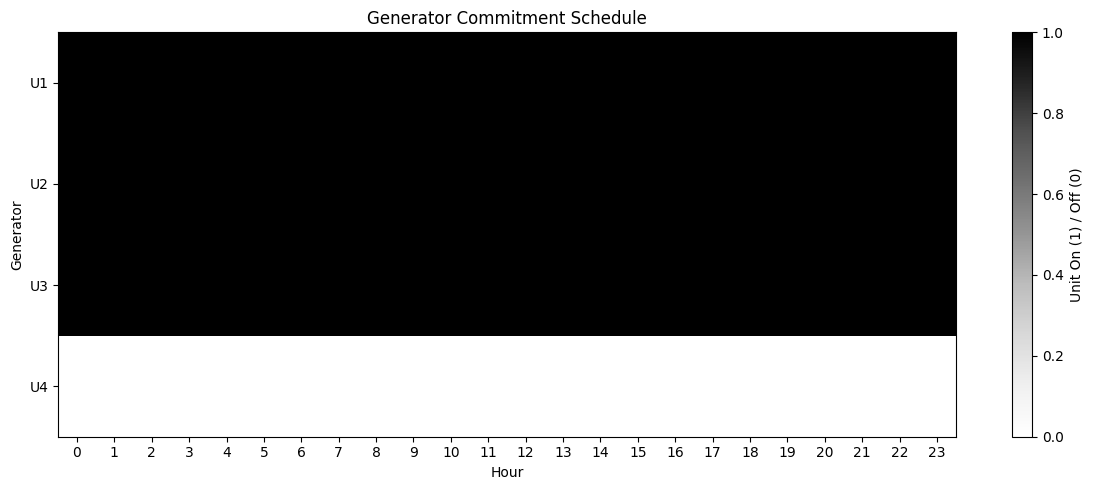

Final expected cost (approx) with L-Benders = 128086.27


In [33]:
import logging
import sys

log = logging.getLogger("LBenders")
log.setLevel(logging.INFO)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# Recommended solvers — adjust to available ones
MASTER_SOLVER = 'gurobi'
LP_SOLVER = 'gurobi'

# L Benders hyperparameters
M_shed = 1e5

def get_solver(name):
    try:
        s = pyo.SolverFactory(name)
        if s is None or not s.available():
            raise RuntimeError(f"Solver {name} not available")
        return s
    except Exception as e:
        log.warning("Solver %s unavailable: %s", name, e)
        return None

master_solver = get_solver(MASTER_SOLVER) or get_solver('cbc') or get_solver('glpk')
lp_solver     = get_solver(LP_SOLVER)     or get_solver('cbc') or get_solver('glpk')

log.info("Master solver = %s, LP solver = %s",
         master_solver.name if master_solver else None,
         lp_solver.name if lp_solver else None)

# ---------------------------
# Helper: compute worst-case total load per time
# ---------------------------
def compute_max_total_load_per_t(scenarios, S_list, nb, T):
    """
    scenarios: dict mapping s -> dict mapping bus -> list/array of loads across T
    S_list: list of scenario keys
    nb: number of buses (0..nb-1)
    T: list of times
    Returns: dict max_load_t[t] = max_s sum_b D[s][b][t]
    """
    max_load_t = {t: 0.0 for t in T}
    for t in T:
        worst = 0.0
        for s in S_list:
            # sum load across buses that exist in scenario s
            tot = 0.0
            for b in range(nb):
                if b in scenarios[s]:
                    # scenarios[s][b] is indexable by t
                    tot += float(scenarios[s][b][t])
                else:
                    # treat missing bus as zero load
                    tot += 0.0
            if tot > worst:
                worst = tot
        max_load_t[t] = worst
    return max_load_t

# compute once before LB loop:
S_list = list(scenarios.keys())
max_load_t = compute_max_total_load_per_t(scenarios, S_list, nb, T)

# ---------------------------
# Updated master builder with load-covering constraints
# ---------------------------
def build_master_with_cuts_and_loadcover(cuts, S_list, G_list, T, SU, u_init, max_load_t,
                                         allow_shed_fraction=0.0, reserve_mw=0.0):
    """
    cuts: list of {'scenario': s, 'alpha':..., 'beta':{(g,t):...}}
    max_load_t: dict t -> worst-case total load across scenarios
    allow_shed_fraction: fraction of load allowed to be shed (epsilon). 0 means no shed allowed.
    reserve_mw: additional capacity margin to require (optional)
    """
    M = pyo.ConcreteModel()
    M.G = pyo.Set(initialize=G_list)
    M.T = pyo.Set(initialize=T)
    M.S = pyo.Set(initialize=S_list)

    M.u = pyo.Var(M.G, M.T, domain=pyo.Binary)
    M.y = pyo.Var(M.G, M.T, domain=pyo.Binary)
    M.theta = pyo.Var(M.S, bounds=(0.0, None))

    def obj_rule(m):
        return sum(SU[g] * m.y[g,t] for g in m.G for t in m.T) + sum(pi[s] * m.theta[s] for s in m.S)
    M.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    # startup linking constraint: y >= u - u_prev
    M.startup_link = pyo.ConstraintList()
    for g in G_list:
        for t in T:
            if t == T[0]:
                M.startup_link.add(M.y[g,t] >= M.u[g,t] - u_init[g])
            else:
                M.startup_link.add(M.y[g,t] >= M.u[g,t] - M.u[g,t-1])

    # Benders cuts
    M.cuts = pyo.ConstraintList()
    for cut in cuts:
        s = cut['scenario']
        alpha = cut['alpha']
        beta = cut['beta']
        M.cuts.add(M.theta[s] >= alpha + sum(beta[(g,t)] * M.u[g,t] for g in G_list for t in T))

    # ---------- NEW: load-covering constraints ----------
    # require available max capacity >= (1-allow_shed_fraction) * max_load_t[t] + reserve_mw
    M.load_cover = pyo.ConstraintList()
    for t in T:
        rhs = (1.0 - allow_shed_fraction) * float(max_load_t[t]) + float(reserve_mw)
        # ensure rhs is not negative
        rhs = max(rhs, 0.0)
        M.load_cover.add(sum(Pmax[g] * M.u[g,t] for g in G_list) >= rhs)

    return M

################################################################
# 2. L-Benders main loop
################################################################
def run_lbenders(G_list, T, S_list, SU, u_initial, max_load_t, max_iters=30, tol=1e-5):

    cuts = []

    for k in range(max_iters):

        log.info(f"=== L-Benders Iteration {k}, existing cuts = {len(cuts)} ===")

        # Build the master
        M = build_master_with_cuts_and_loadcover(cuts, S_list, G_list, T, SU, u_initial, max_load_t,
                                         allow_shed_fraction=0.0, reserve_mw=0.0)
        resM = master_solver.solve(M, tee=False)
        if resM.solver.termination_condition not in (
            pyo.TerminationCondition.optimal,
            pyo.TerminationCondition.feasible,
        ):
            raise RuntimeError(f"Master solve failed: {resM.solver.termination_condition}")

        # Extract integer u_k
        u_k = {(g,t): int(round(pyo.value(M.u[g,t]))) for g in G_list for t in T}
        log.info(f"Master solution u_k: {u_k}")

        # Compute startups in second stage (consistent with your subproblem)
        # But NOTE: startup costs are already included inside the subproblem's objective.
        # So in recourse evaluation Q_s(u_k), fixed startup costs are already added.

        total_Q = 0.0
        newcuts = []
        infeasible_flag = False

        for s in S_list:
            # Build and solve subproblem
            sub = build_dc_subproblem_with_ptdf(u_k, u_initial, s, include_line_limits=True, bigM_shed=M_shed)
            resS = lp_solver.solve(sub, tee=False)
            status = resS.solver.termination_condition
            log.info(f"Scenario {s} Subproblem Status: {status}")
            if status == pyo.TerminationCondition.optimal:
                Qs = pyo.value(sub.obj)
                total_Q += pi[s]*Qs

                # Derive beta_s from duals of constraints where u appears:
                #   sub.cap[g,t]  = p <= Pmax * u_k
                #   sub.minp[g,t] = p >= Pmin * u_k
                beta_s = {(g,t): 0.0 for g in G_list for t in T}

                for g in G_list:
                    for t in T:
                        mu_cap = float(sub.dual.get(sub.cap[g,t], 0.0))    # dual >= 0
                        mu_min = float(sub.dual.get(sub.minp[g,t], 0.0))   # dual >= 0

                        # cap:   p - Pmax*g*u <= 0  ⇒ contribution -Pmax[g]*μ_cap
                        # minp: -p + Pmin*g*u <= 0  ⇒ contribution +Pmin[g]*μ_min
                        beta_s[(g,t)] += -Pmax[g]*mu_cap + Pmin[g]*mu_min

                # Build alpha_s = Q_s(u_k) − beta_s \cdot u_k (robust numerical definition).
                alpha_s = Qs - sum(beta_s[(g,t)]*u_k[(g,t)] for g in G_list for t in T)

                newcuts.append({'scenario': s, 'alpha': alpha_s, 'beta': beta_s})
                log.info(f" Scenario {s}: Qs={Qs:.4f}, alpha_s={alpha_s:.4f}")

            else:
                ########################################################
                # Handle infeasible subproblem (Phase I then no-good cut)
                ########################################################
                log.warning(f" Subproblem for scenario {s} INFEASIBLE. Running Phase I.")
                feas = build_feasibility_elastic_subproblem(u_k, u_init, s, include_line_limits=True, bigM_shed=M_shed)
                resF = lp_solver.solve(feas, tee=False)

                if resF.solver.termination_condition != pyo.TerminationCondition.optimal:
                    # fallback no-good cut forbidding this u
                    log.warning(" Phase I failed so adding no-good cut")
                    alpha_ng = 1e9
                    beta_ng = {(g,t): 0.0 for g in G_list for t in T}
                    newcuts.append({'scenario': s, 'alpha': alpha_ng, 'beta': beta_ng})
                    infeasible_flag = True
                    break

                slack = pyo.value(feas.obj)
                if slack > 1e-6:  # truly infeasible
                    log.warning(f" Phase I slack = {slack} ⇒ no-good cut")
                    alpha_ng = 1e9
                    beta_ng = {(g,t): 0.0 for g in G_list for t in T}
                    newcuts.append({'scenario': s, 'alpha': alpha_ng, 'beta': beta_ng})
                    infeasible_flag = True
                    break
                else:
                    # feasible after elastic — treat recourse cost = 0
                    Qs = 0.0
                    beta_s = {(g,t): 0.0 for g in G_list for t in T}
                    alpha_s = 0.0
                    newcuts.append({'scenario': s, 'alpha': alpha_s, 'beta': beta_s})

        # Add all new cuts
        cuts.extend(newcuts)

        if infeasible_flag:
            continue

        # Evaluate first-stage cost (startup fixed cost)
        fixed_cost = sum(SU[g]*pyo.value(M.y[g,t]) for g in G_list for t in T)
        true_obj = fixed_cost + total_Q
        est_obj  = pyo.value(M.obj)

        log.info(f" Iter {k}: est={est_obj:.4f}, true={true_obj:.4f}")

        if abs(est_obj - true_obj) <= tol:
            log.info(" Converged (est ≈ true).")
            break

    # Final solve
    Mfinal = build_master_with_cuts_and_loadcover(cuts, S_list, G_list, T, SU, u_initial, max_load_t,
                                         allow_shed_fraction=0.0, reserve_mw=0.0)
    resMf = master_solver.solve(Mfinal, tee=False)

    u_final = {(g,t): int(round(pyo.value(Mfinal.u[g,t]))) for g in G_list for t in T}
    y_final = {(g,t): int(round(pyo.value(Mfinal.y[g,t]))) for g in G_list for t in T}
    obj_final = pyo.value(Mfinal.obj)

    log.info(f" Final UC Objective = {obj_final:.4f}")

    return u_final, y_final, obj_final, cuts

# Your global variables:
# G_list, T, u_initial, Pmax, Pmin, SU,
# gen_bus, PTDF, nb, nlines, scenarios, pi, etc.

u_star, y_star, obj, cuts = run_lbenders(
    G_list=G_list,
    T=T,
    S_list=Sred,
    SU=SU,
    u_initial=u_initial,
    max_load_t=max_load_t,
    max_iters=40,
    tol=1e-4
)

plot_commitment(u_star, G_list, T)
print(f'Final expected cost (approx) with L-Benders = {obj:.2f}')

The L-Benders solution to the stochastic UC problem is close as the solution provided by Progressive Hedging to the same problem with optimal objective of 128086.27 (with PH having an optimal objective of 129053.20). The optimal solution is turn on generators U1, U2 and U3 for all time (24 hours in duration). The above logging output shows that L-Benders converged in 4 iterations and added 80 optimality cuts (1 cut for each of the 20 scenarios in our reduced set of scenarios per iteration) and no infeasibility cuts.  

# 4. Robust UC — Worst-case and Budgeted Uncertainty formulations

Robust optimization addresses uncertainty by replacing expectation with a maximization over an uncertainty set.

## (A) Worst-case (min-max) robust UC

Formulation:

$$
\min_{u,y,p,sh} \max_{d\in\mathcal D} \Big \{ \sum_{t,g} C^{\text{var}}_g p_{g,t}(d) + \sum_{t,g} SU_g y_{g,t} + M_{\text{shed}}\sum_{b,t} sh_{b,t}(d) \Big\}
$$

where $\mathcal D$ is the uncertainty set of possible net-load trajectories (over buses and times), e.g. $\mathcal D=\{d^s : s\in S\}$ (finite-scenario worst case).

If $\mathcal D$ is the finite set of scenario loads, the min-max reduces to:

$$
\min_{u,y} \max_{s\in S} Q_s(u),
$$

or equivalently introduce $\theta$ to represent worst-case recourse cost:

$$
\min_{u,y,\theta} \sum_{g,t} SU_g y_{g,t} + \theta \quad\text{s.t.}\quad \theta \ge Q_s(u)\quad \forall s\in S.
$$

This master with constraints $\theta \ge Q_s(u)$ is a robust counterpart; again $Q_s(u)$ is the optimal recourse for that scenario. This is conservative: it optimizes against the single worst scenario.

**Interpretation**: Minimizes the cost under the worst possible load realization in $\mathcal D$. Often highly conservative — large shedding if peak demand exceeds capacity.

## (B) Budgeted uncertainty (Bertsimas–Sim)

Budgeted uncertainty allows controlling conservatism with a budget parameter $\Gamma$ (per time or per region). It models each uncertain parameter as:

$$
d_{b,t} = \hat d_{b,t} + \delta_{b,t},\qquad \delta_{b,t}\in[-\Delta_{b,t}, \Delta_{b,t}],
$$

and assumes that at most $\Gamma_t$ buses can simultaneously take their worst-case deviation (or partially deviate). For a linear constraint of the form $\sum_b a_{b} d_b \le rhs$, its robust counterpart under budgeted uncertainty can be formulated (Bertsimas & Sim 2004) as:

$$
\sum_b a_b \hat d_b + \max_{S\subseteq B, |S|\le\Gamma} \sum_{b\in S} a_b \Delta_b \le rhs,
$$

which can be linearized (via sorting or dualization). For our UC the natural place to robustify is the **demand balance**: the worst extra demand at time $t$ is the sum of the $\Gamma$ largest deviations across buses. Thus robustifying total demand with Gamma yields:

* Let $\hat D_t = \sum_b \hat d_{b,t}$ be nominal total demand and $\Delta_{b,t}$ deviations. The worst additional demand at time $t$ is
  $$
  \text{extra}_t(\Gamma) = \max_{0 \leq z_b \leq 1, \sum_b z_b \leq \Gamma} \sum_b z_b \Delta_{b,t},
  $$
  where $z_b$ indicates whether bus $b$ deviates. This linear program has dual, giving the closed form:

  let $u_t$ be dual variable for $\sum_b z_b \leq \Gamma$ and $v_{b,t}$ duals for $z_b\le1$. By duality, the robustified constraint becomes:

  $$
  \sum_g p_{g,t} + \sum_b W_{b,t} - \hat D_t + sh_t \geq \max_{z}\sum_b z_b \Delta_{b,t}
  $$

  which after dualization equals:

  $$
  \sum_g p_{g,t} + \sum_b W_{b,t} - \hat D_t + sh_t \geq \Gamma u_t + \sum_b \max(0, \Delta_{b,t}-u_t),
  $$

  and one can linearize $\max$ by ordering $\Delta_{b,t}$ or by introducing auxiliary vars. Practical implementations often approximate this by summing the top-$\Gamma$ deviations (sorted $\Delta$). For small systems you can precompute $\text{extra}_t(\Gamma)$ as sum of the $\Gamma$ largest $\Delta_{b,t}$.

**Bertsimas–Sim linearization (system-level)**

A simpler, conservative but implementable approach: at each time $t$ precompute the $\Gamma$ largest deviations over buses and set:

$$
\text{extra}_t(\Gamma) \approx \sum_{b\in B_t^\Gamma} \Delta_{b,t}^{\text{(largest)}},
$$

and enforce:

$$
\sum_g p_{g,t} + \sum_b W_{b,t} - \hat D_t + sh_t \ge \text{extra}_t(\Gamma).
$$

This yields a single deterministic robust constraint with tunable conservatism via $\Gamma$.

**Full dualization**: one can derive an exact linear robust counterpart by introducing variables and the dual of the inner maximization — this yields extra linear constraints and variables but no integer variables. See Bertsimas & Sim (2004) for the exact recipe.


INFO:gurobipy:Warning: row 976 (name "c_e_x1770_") contains 3 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 977 (name "c_e_x1772_") contains 6 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 978 (name "c_e_x1774_") contains 9 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 979 (name "c_e_x1776_") contains 12 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 980 (name "c_e_x1778_") contains 15 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 981 (name "c_e_x1780_") contains 18 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 982 (name "c_e_x1782_") contains 21 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 983 (name "c_e_x1784_") contains 24 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 984 (name "c_e_x1786_") contains 27 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 985 (name "c_e_x1788_") contains 30 smal

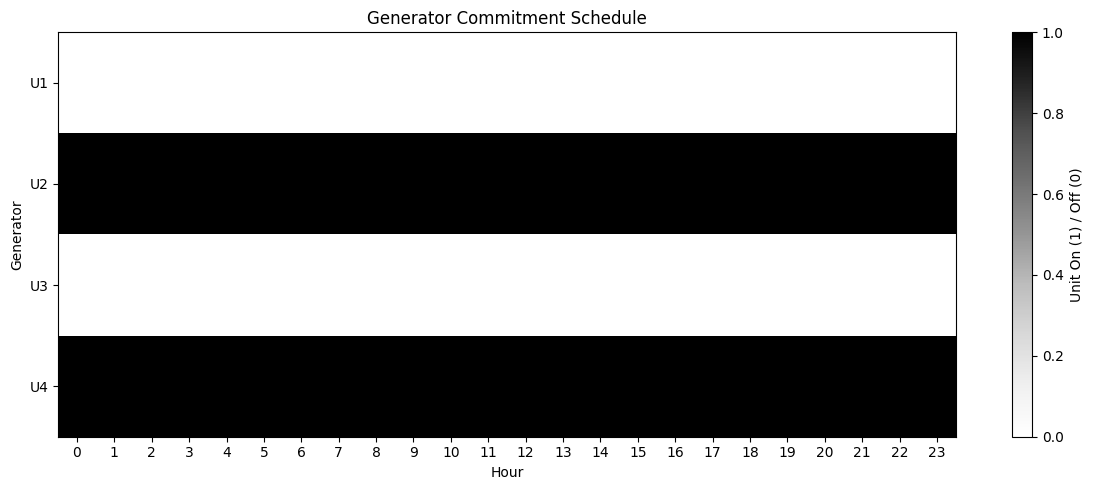

Robust UC Total Shedding is 4876.763765463057 MW.
INFO:gurobipy:Warning: row 640 (name "c_e_x1434_") contains 3 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 641 (name "c_e_x1436_") contains 6 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 642 (name "c_e_x1438_") contains 9 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 643 (name "c_e_x1440_") contains 12 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 644 (name "c_e_x1442_") contains 15 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 645 (name "c_e_x1444_") contains 18 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 646 (name "c_e_x1446_") contains 21 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 647 (name "c_e_x1448_") contains 24 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:Warning: row 648 (name "c_e_x1450_") contains 27 small (<= 1e-13) coefficient(s), ignored
INFO:gurobipy:War

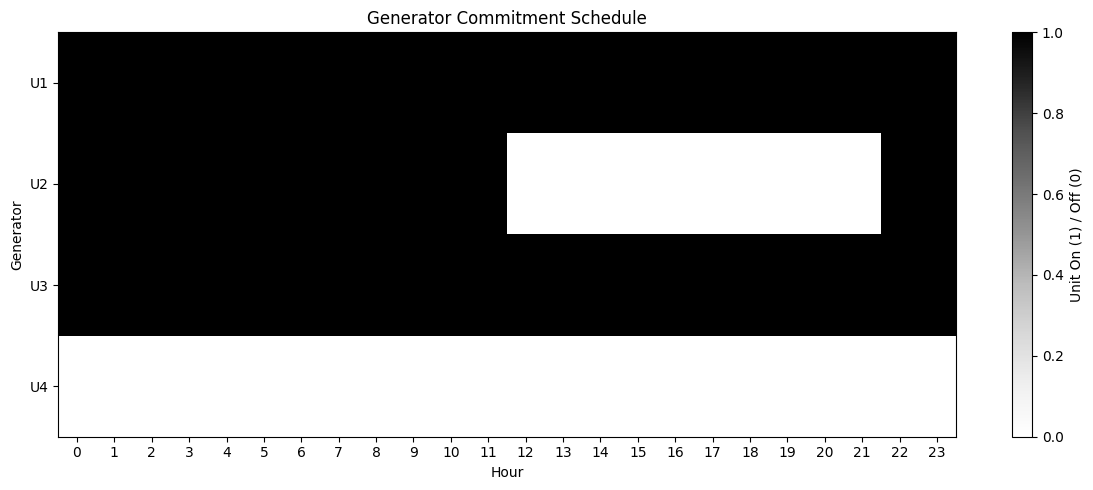

Budgeted Robust UC Total Shedding is 0.0 MW.


In [35]:
# Robust UC: worst-case
Dworst_bus = {b: {t: max(scenarios[s][b][t] for s in Sred) for t in T} for b in range(nb)}
Wworst_bus = {b: {t: min(wind_scenarios[s][b][t] for s in Sred) for t in T} for b in wind_buses}  # we did not model wind per-scenario in detail here

robust_model = build_deterministic_uc(Dworst_bus, Wworst_bus, u_initial)
robust_solver = None
for cand in ('gurobi','cplex','cbc'):
    try:
        if pyo.SolverFactory(cand).available():
            robust_solver = pyo.SolverFactory(cand); break
    except Exception:
        pass
if robust_solver is None:
    robust_solver = pyo.SolverFactory('cbc') if pyo.SolverFactory('cbc').available() else pyo.SolverFactory('glpk')

resR = robust_solver.solve(robust_model, tee=False)
print('Robust UC Status:', resR.solver.termination_condition)
print(f'Final expected cost (approx) with Budgeted Robust UC = {pyo.value(robust_model.obj):.2f}')
print("Optimal Robust UC Solution u:")
u_robust = {(g,t): int(round(pyo.value(robust_model.u[g,t]))) for g in G_list for t in T}
plot_commitment(u_robust, G_list, T)
shed_total = sum(pyo.value(robust_model.shed_bus[b,t]) for b in range(nb) for t in T)
print(f'Robust UC Total Shedding is {shed_total} MW.')

# Budgeted uncertainty (system-level Gamma): implement a simple robustification of total demand per t
Gamma = 3  # number of buses that can realize worst-case deviation simultaneously
D_hat = {b: {t: np.mean([scenarios[s][b][t] for s in Sred]) for t in T} for b in range(nb)}
D_dev = {b: {t: max(scenarios[s][b][t] for s in Sred) - D_hat[b][t] for t in T} for b in range(nb)}

def build_budgeted_robust_uc(Gamma):
    m = pyo.ConcreteModel()
    m.G = pyo.Set(initialize=G_list); m.T = pyo.Set(initialize=T); m.B = pyo.Set(initialize=list(range(nb)))
    m.u = pyo.Var(m.G, m.T, domain=pyo.Binary)
    m.y = pyo.Var(m.G, m.T, domain=pyo.Binary)
    m.p = pyo.Var(m.G, m.T, domain=pyo.NonNegativeReals)
    m.shed = pyo.Var(m.B, m.T, domain=pyo.NonNegativeReals)
    m.f = pyo.Var(range(nlines), m.T, domain=pyo.Reals)
    bigM = 1e5
    # objective
    m.obj = pyo.Objective(expr=sum(SU[g]*m.y[g,t] for g in m.G for t in m.T) + sum(var_cost[g]*m.p[g,t] for g in m.G for t in m.T) + bigM*sum(m.shed[b,t] for b in m.B for t in m.T), sense=pyo.minimize)
    # startup link
    def start_rule(m,g,t):
        if t==0:
            return m.y[g,t] >= m.u[g,t] - int(u_initial[g])
        return m.y[g,t] >= m.u[g,t] - m.u[g,t-1]
    m.start = pyo.Constraint(m.G, m.T, rule=start_rule)
    # cap/min/ramp
    m.cap = pyo.Constraint(m.G, m.T, rule=lambda m,g,t: m.p[g,t] <= Pmax[g] * m.u[g,t])
    m.minp = pyo.Constraint(m.G, m.T, rule=lambda m,g,t: m.p[g,t] >= Pmin[g] * m.u[g,t])
    def rup(m,g,t):
        if t==0: return pyo.Constraint.Skip
        return m.p[g,t] - m.p[g,t-1] <= RU[g]
    def rdn(m,g,t):
        if t==0: return pyo.Constraint.Skip
        return m.p[g,t-1] - m.p[g,t] <= RD[g]
    m.rup = pyo.Constraint(m.G, m.T, rule=rup)
    m.rdn = pyo.Constraint(m.G, m.T, rule=rdn)
    
    def worst_extra_demand_and_buses(t, Gamma, D_dev, nb):
        # create list of (deviation, bus_index)
        devs = [(D_dev[b][t], b) for b in range(nb)]
        # sort descending by deviation
        devs_sorted = sorted(devs, key=lambda x: x[0], reverse=True)
        # pick top Gamma entries
        top = devs_sorted[:Gamma]
        return dict(top)
    
    m.worst_extra_load_and_buses = {t: worst_extra_demand_and_buses(t, Gamma, D_dev, nb) for t in T}
    
    def inj_expr(m, b, t):
        gen_term = sum(m.p[g,t] for g in m.G if gen_bus[g] == b)
        load_bt = float(scenarios[s][b][t]) if b in scenarios[s] else 0.0
        wind_bt = 0.0  # we used scenario_total_wind aggregated earlier; per-bus wind set to 0 unless provided
        worst_extra_bt = m.worst_extra_load_and_buses[t][b] if b in m.worst_extra_load_and_buses[t].keys() else 0.0
        return gen_term - load_bt + wind_bt + m.shed[b,t] + worst_extra_bt
    # link flows via PTDF: f_l = sum_b PTDF[l,b] * inj_b
    def flow_def_rule(m,l,t):
        return m.f[l,t] == sum(float(PTDF[l,b]) * inj_expr(m,b,t) for b in range(nb))
    m.flow_def = pyo.Constraint(range(nlines), m.T, rule=flow_def_rule)
    def bus_balance(m, t):
        return sum(inj_expr(m, b, t) for b in m.B) == 0
    m.balance = pyo.Constraint(m.T, rule=bus_balance)
    return m

br_model = build_budgeted_robust_uc(Gamma)
resBR = robust_solver.solve(br_model, tee=False)
print('Budgeted Robust UC Status:', resBR.solver.termination_condition)
print(f'Final expected cost (approx) with Budgeted Robust UC = {pyo.value(br_model.obj):.2f}')
print("Optimal Budgeted Robust UC Solution u:")
u_br = {(g,t): int(round(pyo.value(br_model.u[g,t]))) for g in G_list for t in T}
plot_commitment(u_br, G_list, T)
shed_br = sum(pyo.value(br_model.shed[b,t]) for b in range(nb) for t in T)
print(f'Budgeted Robust UC Total Shedding is {shed_br} MW.')


Using the robust UC formulation that assumes worst case demand, we get a somewhat undesirable solution where the generators U2 and U4 are turned on for all time with heavy load shedding of 4875.56 MW and expected cost of 487727348.13. To rectify this, we can use the Bertsimas-Sim method to acheive a more desirable solution where there is no load shedding and generators U1, U2 and U3 are turned on with generator U2 being shut off in the middle between the 12th and 22nd hour and a lower expected cost of 128643.64 that is closer to the expected cost of the solution provided by Progressive Hedging and L-Benders.

# 5. Practical notes: choosing modeling options, cuts, and debugging

* **Startup costs in master**: Always charge the startup **only** when a start occurs, i.e. via $y$ variables or $y\ge u_t-u_{t-1}$. Do **not** put $SU\cdot u_{g,t}$ in the master as that makes being ON every period paid repeatedly and biases optimization.

* **PH penalty selection**: start $\rho$ on the same order of magnitude as first-stage costs (SU) for $u$ and variable costs for $p$. If you see PH stall, try:

  * increase $\rho_u$ (×2–10),
  * penalize $p$ (nonzero $\rho_p$),
  * use adaptive $\rho$ (increase when progress stalls).

* **PH integerization**: prefer a small MILP postprocessing that finds integer $u$ nearest to $\bar u$ subject to logical UC constraints. This reduces poor rounding artifacts.

* **Benders duals**:

  * If your LP solver exposes duals via Pyomo `Suffix`, use them to compute $\beta$ terms (subgradients).
  * If not, use aggregated $\alpha$ only cuts or change LP solver (Gurobi/Cplex recommended).

* **Feasibility in subproblems**:

  * Add load shedding $sh$ with large penalty to keep subproblems feasible and provide cost signal for infeasibility.
  * If a subproblem is infeasible despite shedding, the master $u$ is invalid; use Phase-I elastic subproblem and add feasibility cut (ray) or no-good cut forbidding $u^k$.

* **Multi-cut vs single-cut**:

  * Multi-cut is stronger and often converges faster for stochastic UC, at the cost of larger master.
  * Single aggregated cut is simpler but may need more iterations.

* **PTDF & DCOPF**: ensure PTDF is consistent (columns sum to zero, sign conventions). Mistakes in PTDF map can create imbalanced flows and infeasibilities.

* **Min-up/min-down**: neglecting these often yields unrealistic frequent cycling; include them if realism required. They complicate PH (since $u$ must respect temporal coupling) — PH can still handle them, but integerization step must enforce them.

## 6. AWS Deployment Mock (Docker + Terraform/CloudFormation + Dask)

We can deploy the Pyomo stochastic OPF pipeline on AWS using:
- Docker image with Python, Pyomo, IPOPT, GLPK, CBC
- Dask for parallel scenario solves
- Terraform or CloudFormation for job orchestration


In [36]:
# Dockerfile example
real_docker_snippet = '''
FROM python:3.11-slim
RUN apt-get update && apt-get install -y coinor-ipopt coinor-cbc glpk-utils && rm -rf /var/lib/apt/lists/*
RUN pip install --no-cache-dir pyomo numpy scipy matplotlib tensorflow dask[distributed]
WORKDIR /app
COPY . /app
CMD ["jupyter", "notebook", "--ip=0.0.0.0", "--allow-root"]'''

In [37]:
real_terraform_snippet = '''
# Terraform mock for AWS Batch job definition
resource "aws_batch_job_definition" "opf_job" {
  name = "opf-pipeline-job"
  type = "container"
  container_properties = jsonencode({
    image: "mydockerhub/opf:latest",
    vcpus: 4,
    memory: 8192,
    command: ["python", "run_opf_pipeline.py"],
    environment: [ { name: "NUM_SCENARIOS", value: "16" } ]
  })
}'''

In [38]:
# Dask parallel execution sketch
from dask.distributed import Client, LocalCluster
import numpy as np

cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

def solve_scenario(wind_scenario):
    return wind_scenario.sum()  # placeholder

wind_scenarios = [np.random.rand(3)*20 for _ in range(16)]
futures = client.map(solve_scenario, wind_scenarios)
results = client.gather(futures)
print("Parallel scenario results:", results)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-uvrh63q3', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-pqq70cm_', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-t967zse0', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-kf562cy2', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-401eiv38', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:35837
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Sta

## Final notes

This comprehensive notebook contains DC-OPF + AC-OPF solutions for a toy 3-bus problem as well as Progressive Hedging, L-Benders and robust optimization solutions (assuming either worst-case demand or Bertsimas-Sim style budgeted uncertainty assumptions) to the stochastic unit commitment problem for IEEE-14 network with 2 wind turbines added. It concludes by showing a mock AWS integration with parallelizing computation across scenarios with Dask parallel processing framework.